# Sample notebook for predicting prices of real estates with AdaBoost

In [1]:
# Import packages
from IPython.display import Image, display, HTML
import json
import keplergl 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold, GridSearchCV
import requests
import re

# Set display options for pandas DataFrames and Series
pd.options.display.max_colwidth = 100

/Users/louis/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 1. Import train and test set

In [2]:
# Load the training and test data
train = pd.read_csv('train.csv', index_col='Uniq Id')
test = pd.read_csv('test.csv', index_col='Uniq Id')

In [3]:
# Get size of the training data
train.shape

(20000, 23)

In [4]:
# Get size of the test data
test.shape

(5000, 22)

## 2. Exploratory data analysis

In [5]:
# Visualize all real estates on a map (internet connection required)
house_map = keplergl.KeplerGl(height=800, data={'data': train}, config=requests.get('https://api.npoint.io/663d9c97c3c5cd411a28').json())
house_map


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'config': {'mapState': {'zoom': 2.834109438549707, 'pitch': 0, 'bearing': 0, 'isSplit': False…

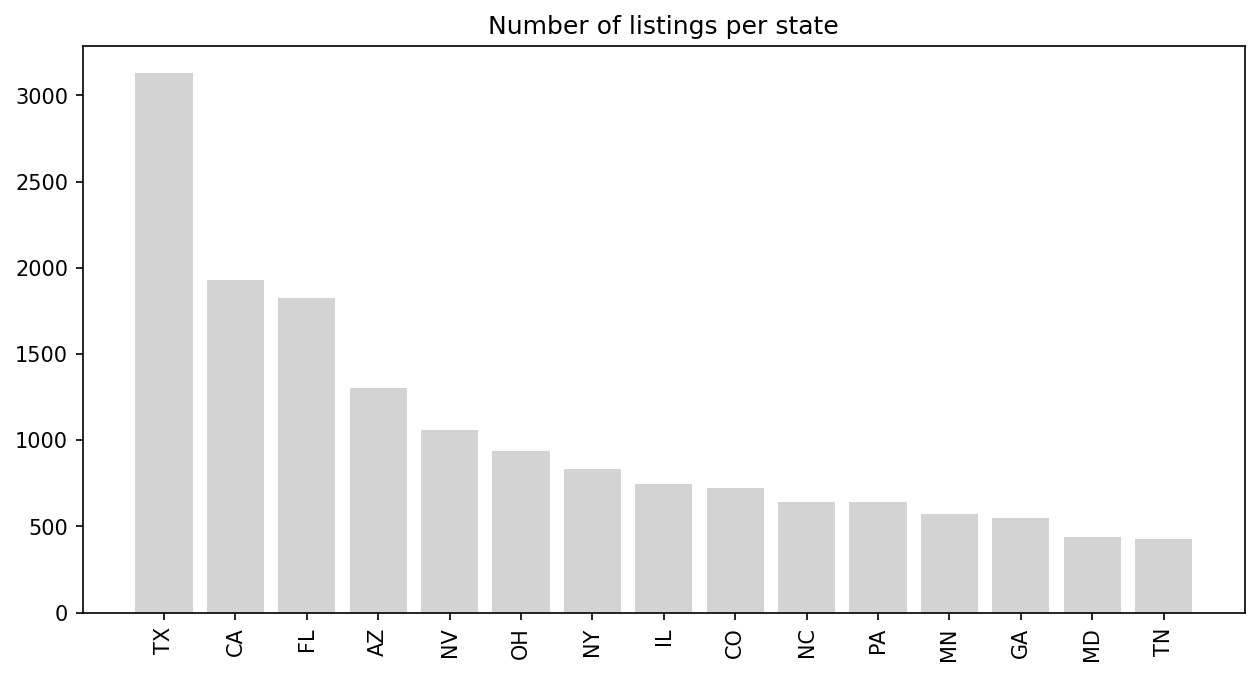

In [6]:
#Identify most popular states
most_popular_states = train['State'].value_counts().head(15)
plt.figure(figsize=(10, 5), dpi=150)
plt.xticks(rotation=90)
plt.bar(most_popular_states.index, most_popular_states, color='lightgray')
plt.title('Number of listings per state');

## 3. Data cleaning

In [7]:
# Clean the price information
def clean_prices(df):
    
    # Remove dollar sign 
    df.Price = df.Price.str.replace('$', '', regex=False)
    
    # Remove the commas
    df.Price = df.Price.str.replace(',', '', regex=False)
    
    # Convert string to numerical value ('coerce' will set a NaN value if invalid parsing)
    df.Price = pd.to_numeric(df.Price, errors='coerce')
    
    # Return cleaned DataFrame
    return df

In [8]:
# Clean the squarefeet information
def clean_feature_squarefeet(df):
    
    # Remove the commas
    df['Sqr Ft'] = df['Sqr Ft'].str.replace(',', '', regex=False)
    

    # Remove sqft string
    df['Sqr Ft'] = df['Sqr Ft'].str.replace('sqft', '', regex=False)
    
    # Convert string to numerical value ('coerce' will set a NaN value if invalid parsing)
    df['Sqr Ft'] = pd.to_numeric(df['Sqr Ft'], errors='coerce')
    
    df['Sqr Ft'] = df.groupby(['State'],dropna=False)['Sqr Ft'].apply(lambda x: x.fillna(x.median()))
                          
    
    # Return cleaned DataFrame
    return df

In [9]:
def convert_acres_to_sqft(acres):
    '''
    This function takes as input an integer or floating number representing the number of acres of a property 
    and return another integer or floating number corresponding to transformed value in inches
    '''
    sqft = acres * 43560 
    return sqft

In [10]:
def extract_numerical_elements(str1):
    '''
    This function takes as input a string and return a floating number,after extracting all the numerical elements
    from the string.
    '''
    return float(" ".join(re.findall(r'-?\d+\.?\d*', str1)))

In [11]:
def clean_lot_size(df):
    
    # Fill na values with a huge number to avoid errors on the next line of code
    df['Lot Size'] = df['Lot Size'].fillna('8000000000')
    
    # strip() to remove extra space before and after the  string and replace spaces and commas with nothing
    df['Lot Size'] = [i.strip().replace(" ", "").replace(',', '') for i in df['Lot Size']]
    
    
    for i in df['Lot Size']:
        if 'acres' in i:
            x= convert_acres_to_sqft(extract_numerical_elements(i))
            df['Lot Size'] = df['Lot Size'].replace(i, x)
        if 'sqft' in i:
            y = extract_numerical_elements(i)
            df['Lot Size'] = df['Lot Size'].replace(i, y)
        else:
            df['Lot Size'] = df['Lot Size'].replace(i, float("NaN"))
            
        
    #replace na values with the median by state
    df['Lot Size'] = df.groupby(['State'],dropna=False)['Lot Size'].apply(lambda x: x.fillna(x.median()))

    df['Lot Size'] =  pd.to_numeric(df['Lot Size'].round(2), errors='coerce')
    
    
    return df




In [12]:
# Execute clean_prices(df) function to clean prices in training set
# Execute clean_feature_squarefeet(df) function to clean sqft in training and testing set
# Execute clean_lot_size(df)) function to clean lot size in training and testing set


train = clean_prices(train)
train = clean_feature_squarefeet(train)
train = clean_lot_size(train) # This function takes quite some time to run


test = clean_feature_squarefeet(test)
test = clean_lot_size(test)

In [13]:
#check if implemented correctly

test['Lot Size']

Uniq Id
dfba9eb1dadb1f143d60559f55cec6e5     7161.0
7d028c98db434a41fe331569d291cdd8    16988.4
2e7f38cdbf0a487177cdda0f5491f9b3     4032.0
143f5b380282138db0ff30d7478f4634     6181.0
e6ff96628ba6c4a1f3453d68f1df8e75     1478.0
                                     ...   
42a9f18319ed4a75e2f9debed35025cf    10380.0
74e3a157d4fae21e79fe89a84dad12d1    62290.8
f5f23a3abd41102b3fa6e73b04b8fc29     4778.0
a32a07ef179d144ca75cb35b2157b4a1     7430.5
9812935d844b5696c2a83ad08c24fc8a     8472.0
Name: Lot Size, Length: 5000, dtype: float64

In [14]:
#check if implemented correctly

test['Sqr Ft']

Uniq Id
dfba9eb1dadb1f143d60559f55cec6e5    1087.0
7d028c98db434a41fe331569d291cdd8    1796.0
2e7f38cdbf0a487177cdda0f5491f9b3    1641.0
143f5b380282138db0ff30d7478f4634    1923.0
e6ff96628ba6c4a1f3453d68f1df8e75    2340.0
                                     ...  
42a9f18319ed4a75e2f9debed35025cf    3089.0
74e3a157d4fae21e79fe89a84dad12d1    1176.0
f5f23a3abd41102b3fa6e73b04b8fc29    1686.0
a32a07ef179d144ca75cb35b2157b4a1    2378.0
9812935d844b5696c2a83ad08c24fc8a    1642.0
Name: Sqr Ft, Length: 5000, dtype: float64

### Relationship between price and state (still part of EDA)

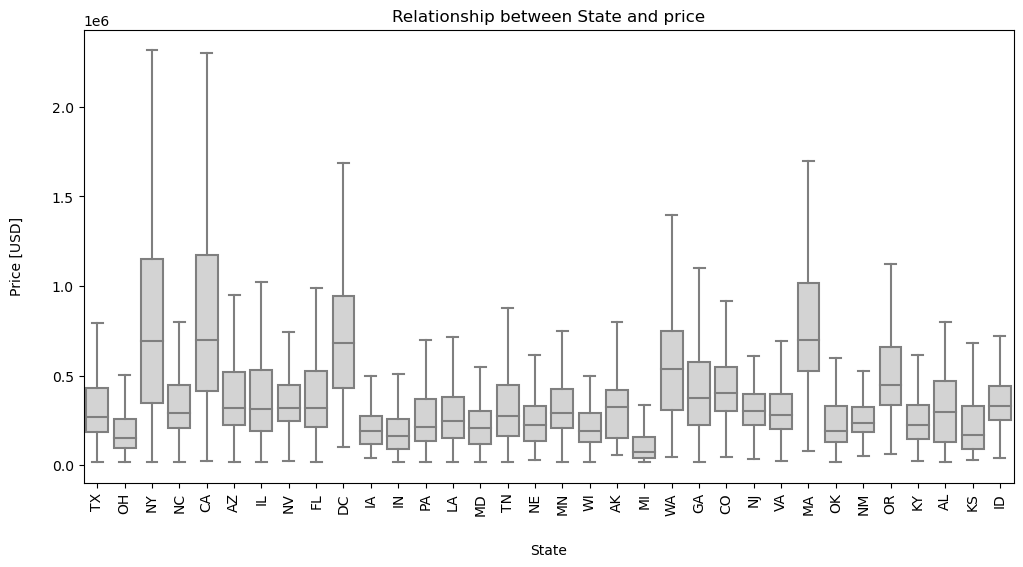

In [15]:
# Inspect relationship between State and price in the training data
# As we can see, houses located in the New York,California, Florida, Washington or Miami seems to be pricier.

plt.figure(figsize=(12, 6), dpi=100)
sns.boxplot(x='State', y='Price', data=train, color='lightgray', showfliers = False)
plt.ylabel('Price [USD]', labelpad=20)
plt.xlabel('State', labelpad=20)
plt.xticks(rotation=90)
plt.title('Relationship between State and price');

## 4. Feature engineering

### Distance Airport

In [16]:
# Calculations were done in a separated notebook to keep the Notebook organised and clean. 
airports= pd.read_csv('Train_set_Airport_dist_column.csv',index_col = 'id')
airports

,dist
id,
0000671ffff7289afcc148b812dac2a5,4292.823663
00033964d5752c469fcc008045ebece8,11362.531603
000a5078118526e529d00f94e188c13d,17702.995644
000bb57ac4248f03522383228c866457,23217.417239
000cc14f1f6e76c1d8853246f4382d9d,15360.528218
...,...
fff5e1c3c00ff0ab4b3f91a1221ed681,25477.556930
fffa6036c5f71f0a5ca12453a3360cee,26067.665060
fffab79983524570cb81e3784e59085a,27115.199062


In [17]:
train['nearby_airport'] = airports['dist']

In [18]:
train['nearby_airport']

Uniq Id
d1051058987a9318579c5f4800b11ec9    31104.908890
d828481dab53c905602da163ae60719a    11821.328249
337035af415268e839adee3721605b14    13427.767877
75c39cde146e32ce3faee4d92966bf5a    23128.290330
a35163a58a636c23fe089e1e66f5c077    16391.519805
                                        ...     
025369af9dcc2b13e6f223bbe46eb1ea    37473.182255
740cff8864ee9b042fd51892d6aa004c    30284.417417
f1ba5ed512162c4371ed1c5c49d4971d    13085.945444
c0f00e2e37768394a9890917185adbca    50338.400992
3c55c25010b7fdf623fd5059c4a55a10     9169.355960
Name: nearby_airport, Length: 20000, dtype: float64

In [19]:
airports_test = pd.read_csv('Test_set_Airport_dist_column.csv',index_col = 'id')
airports_test

,dist
id,
0004dd327362e5ca1a0320b18106f93f,14009.250264
0006d271212b6636bf8c79b3e583ad61,11184.455333
00121c9181a72f24280189693ba3f60a,24080.180296
001b3f3e16490f3a483116558d5d5a3c,16566.535613
002cd7c0874360522b559bbd1055b364,13587.747333
...,...
ff8de0094e78d722bdc7563d9bad30bf,14203.429510
ffa7078adebb4d58884116158c1b5c0f,27040.855694
ffacc3e35a93b4726093b5320602ab6a,2613.568309


In [20]:
test['nearby_airport'] = airports_test['dist']

In [21]:
test['nearby_airport']

Uniq Id
dfba9eb1dadb1f143d60559f55cec6e5    17106.165056
7d028c98db434a41fe331569d291cdd8     4521.095320
2e7f38cdbf0a487177cdda0f5491f9b3    14734.626039
143f5b380282138db0ff30d7478f4634    13601.475419
e6ff96628ba6c4a1f3453d68f1df8e75    13574.650766
                                        ...     
42a9f18319ed4a75e2f9debed35025cf     3613.630973
74e3a157d4fae21e79fe89a84dad12d1    27032.805355
f5f23a3abd41102b3fa6e73b04b8fc29     2956.423903
a32a07ef179d144ca75cb35b2157b4a1     8466.420288
9812935d844b5696c2a83ad08c24fc8a    23076.287821
Name: nearby_airport, Length: 5000, dtype: float64

### Number crimes per city

In [22]:
#Cleaning of the original data set is done in another file to keep the notebook organised and clean
number_crimes = pd.read_csv('Number_Crimes_Per_City.csv')
number_crimes

,City,Number_crimes
0,Abbeville,148
1,Aberdeen,396
2,AberdeenTownship,15
3,Abernathy,2
4,Abilene,468
...,...,...
6284,Zephyrhills,49
6285,Zilwaukee,0
6286,Zion,130
6287,Zionsville,4


In [23]:
train = train.merge(number_crimes, how='left', on ='City') # use how ='left' to ensure that all the values from number_crimes are contained in the new train dataframe.

In [24]:
train.head(1)

,Crawl Timestamp,Url,Title,Description,Price,Style,Sqr Ft,Longitude,Latitude,Home Id,...,Address,City,State,Zipcode,Address Full,Facts,Number of Images,Image,nearby_airport,Number_crimes
0,2019-10-31 01:13:10 +0000,https://www.trulia.com/p/tx/houston/650-cherrybark-ln-houston-tx-77079--1127749802,"650 Cherrybark Ln Houston, TX 77079",LOCATION ! LOCATION ! LOCATION! This property sits on an oversized corner lot in Memorial Plaza...,570000,3 Beds / 2 Baths,2165.0,-95.56353,29.775803,3.232516e+09,...,"650 Cherrybark Ln Houston, TX 77079",Houston,TX,77079.0,"650 Cherrybark Ln, Houston, TX 77079","3 Beds | 2 Baths | 2,165 sqft | Single Family Home | 0.3 acres lot size | Built in 1958 | County...",1,https://www.trulia.com/pictures/thumbs_6/zillowstatic/fp/c2b1bdf4948f1e11c2ed8659fcce4111-full.jpg,31104.90889,25263.0


In [25]:
#reset train index as before
tr = pd.read_csv('train.csv', index_col='Uniq Id')
train.index = tr.index


In [26]:
test = test.merge(number_crimes, how='left', on='City')

In [27]:
test.head(1)

,Crawl Timestamp,Url,Title,Description,Style,Sqr Ft,Longitude,Latitude,Home Id,Lot Size,...,Address,City,State,Zipcode,Address Full,Facts,Number of Images,Image,nearby_airport,Number_crimes
0,2019-10-26 01:26:56 +0000,https://www.trulia.com/p/tx/dallas/1434-garza-ave-dallas-tx-75216--2066388719,"1434 Garza Ave Dallas, TX 75216","This single-family home is located at 1434 Garza Ave, Dallas, TX. 1434 Garza Ave is in the Ceda...",2 Beds / 1 Bath,1087.0,-96.80449,32.698128,5.064108e+09,7161.0,...,"1434 Garza Ave Dallas, TX 75216",Dallas,TX,75216.0,"1434 Garza Ave, Dallas, TX 75216","2 Beds | 1 Bath | 1,087 sqft | Single Family Home | 7,161 sqft lot size | Built in 1940 | County...",8,https://www.trulia.com/pictures/thumbs_6/zillowstatic/fp/dbf66314f3eff07c93acec2dea3a647b-full.jpg,17106.165056,11832.0


In [28]:
#reset test index as before
te = pd.read_csv('test.csv', index_col = 'Uniq Id')
test.index = te.index

In [29]:
test.head(1)

,Crawl Timestamp,Url,Title,Description,Style,Sqr Ft,Longitude,Latitude,Home Id,Lot Size,...,Address,City,State,Zipcode,Address Full,Facts,Number of Images,Image,nearby_airport,Number_crimes
Uniq Id,,,,,,,,,,,,,,,,,,,,,
dfba9eb1dadb1f143d60559f55cec6e5,2019-10-26 01:26:56 +0000,https://www.trulia.com/p/tx/dallas/1434-garza-ave-dallas-tx-75216--2066388719,"1434 Garza Ave Dallas, TX 75216","This single-family home is located at 1434 Garza Ave, Dallas, TX. 1434 Garza Ave is in the Ceda...",2 Beds / 1 Bath,1087.0,-96.80449,32.698128,5.064108e+09,7161.0,...,"1434 Garza Ave Dallas, TX 75216",Dallas,TX,75216.0,"1434 Garza Ave, Dallas, TX 75216","2 Beds | 1 Bath | 1,087 sqft | Single Family Home | 7,161 sqft lot size | Built in 1940 | County...",8,https://www.trulia.com/pictures/thumbs_6/zillowstatic/fp/dbf66314f3eff07c93acec2dea3a647b-full.jpg,17106.165056,11832.0


### Create Property Type

In [30]:
# Create feature called 'Property Type' that indicates the type of the real estate
def create_property_type(df):
    
    # The first entry of the 'Features' column contains information about the property type
    # Extract the property type information from the 'Features' column
    property_type = df['Features'].apply(lambda x: x.split('|')[0])
    
    # Remove trailing white space
    property_type = property_type.str.rstrip()
    
    # Add new feature 'Property Type' to the DataFrame
    df['Property Type'] = property_type
    
    # Return extended DataFrame
    return df

In [31]:
# Add new feature 'Property Type' to training and test data
train = create_property_type(train)
test = create_property_type(test)

In [32]:
test['Property Type']

Uniq Id
dfba9eb1dadb1f143d60559f55cec6e5    Single Family Home
7d028c98db434a41fe331569d291cdd8    Single Family Home
2e7f38cdbf0a487177cdda0f5491f9b3                 Condo
143f5b380282138db0ff30d7478f4634    Single Family Home
e6ff96628ba6c4a1f3453d68f1df8e75    Single Family Home
                                           ...        
42a9f18319ed4a75e2f9debed35025cf    Single Family Home
74e3a157d4fae21e79fe89a84dad12d1                 Condo
f5f23a3abd41102b3fa6e73b04b8fc29             Townhouse
a32a07ef179d144ca75cb35b2157b4a1             Townhouse
9812935d844b5696c2a83ad08c24fc8a    Single Family Home
Name: Property Type, Length: 5000, dtype: object

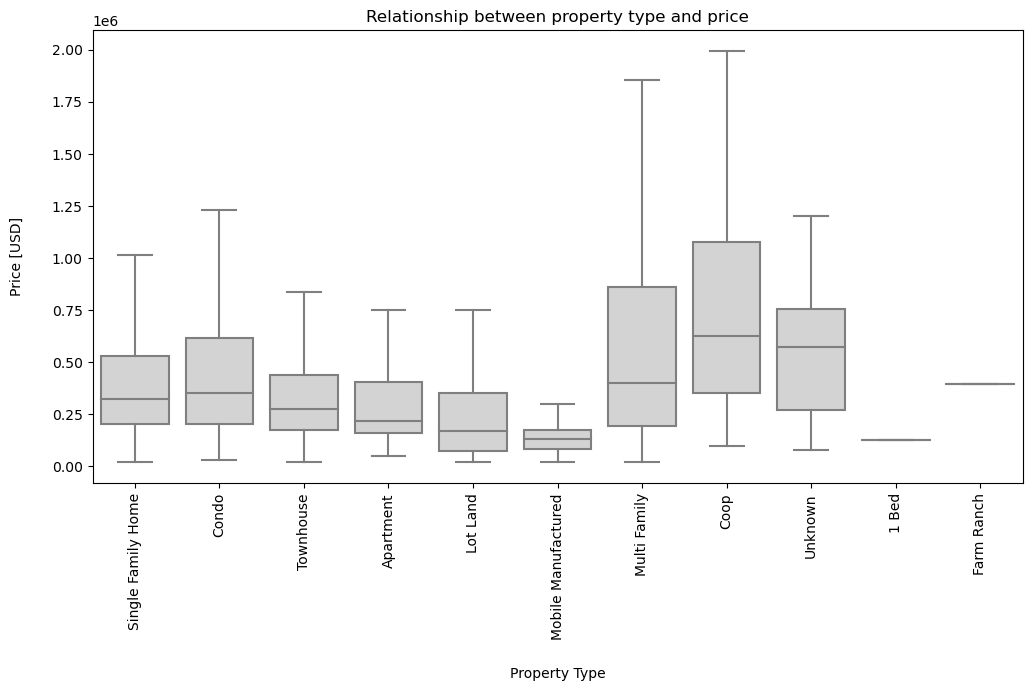

In [33]:
# Inspect relationship between Property type and price in the training data
plt.figure(figsize=(12, 6), dpi=100)
sns.boxplot(x='Property Type', y='Price', data=train, color='lightgray', showfliers = False)
plt.ylabel('Price [USD]', labelpad=20)
plt.xlabel('Property Type', labelpad=20)
plt.xticks(rotation=90)
plt.title('Relationship between property type and price');

### Number of features

In [34]:
def count_features_all(df):
    def count_features(text):
        return len(text.split('|'))
    
    # Create new feature with loop
    num_of_features = []
    for text in df['Features']:
        num_of_features.append(count_features(text))

    num_of_features = pd.Series(num_of_features, index=df.index)    

    # Create new feature (with apply)
    num_of_features = df['Features'].apply(count_features)

    # Add new feature to data frame
    df['num_of_features'] = num_of_features
    
    return df

In [35]:
train = count_features_all(train)
test  = count_features_all(test)

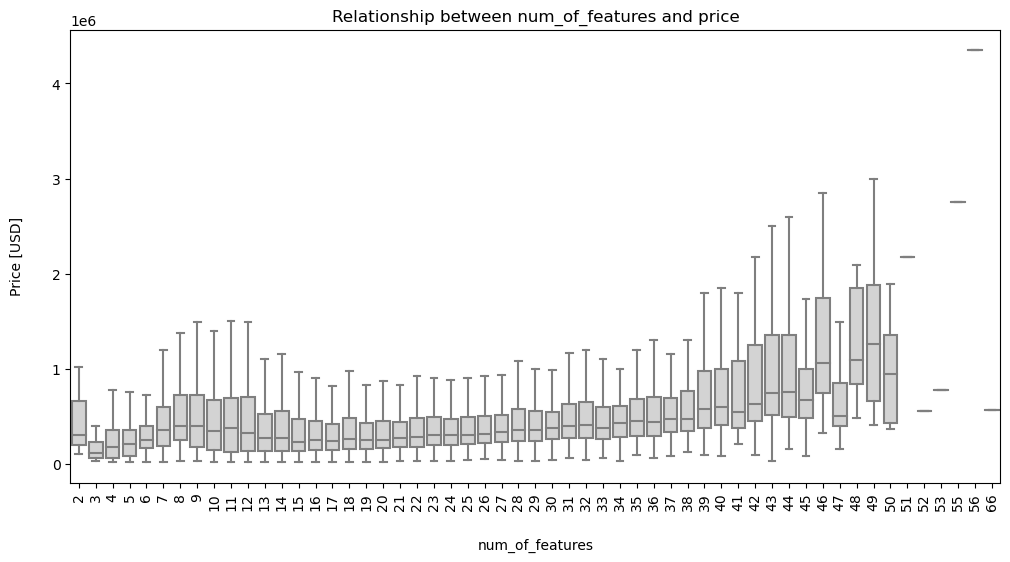

In [36]:
# Inspect relationship between num_of_features and price in the training data
plt.figure(figsize=(12, 6), dpi=100)
sns.boxplot(x='num_of_features', y='Price', data=train, color='lightgray', showfliers = False)
plt.ylabel('Price [USD]', labelpad=20)
plt.xlabel('num_of_features', labelpad=20)
plt.xticks(rotation=90)
plt.title('Relationship between num_of_features and price');

# Create features based on the 'Features'

In [37]:
# get list of feature from the house with the most features and use some of them to create independent feature columns

[i for i in train.loc[train['num_of_features'] == train['num_of_features'].max(),'Features']]

['Single Family Home | $259/sqft | Lot Size: 7,780 sqft | Built in 1973 | 14 Days on Trulia | 5 Rooms | Rooms: Breakfast Nook, Dining Room, Family Room, Laundry Room, Office, Pantry, Recreation Room, Workshop, Walk In Closet | Furnished | Heating: Forced Air | Heating Fuel: Gas | Cooling System: Central | Air Conditioning | Refrigerator | Microwave | Dishwasher | Disposal | Floors: Carpet, Linoleum Vinyl | Great Views | Fireplace | Skylight | Vaulted Ceiling | Double Paned Windows | Ceiling Fan | Wet Bar | Jetted Bath Tub | Parking: Carport, Off Street, Detached Garage, On Street, Attached Garage | Garage | Carport | Rv Parking | Parking Spaces: 8 | Basement | Attic | Storage | Security System | Fitness Center | Barbeque Area | Basketball Court | Tennis Court | Sport Court | Elevator | Doorman | Gated Entry | Intercom | Additional Storage | Cable Ready | Ranch Architecture | Stories: 1 | Exterior: Brick Metal | Roof: Composition | Year Updated: 2018 | Patio | Porch | Deck | Lawn | Gree

In [38]:
# Transform Features column values into lists instead of strings (easier handling afterwards)

train['Features'] = train['Features'].apply(lambda x: x.split('|'))
test['Features'] = test['Features'].apply(lambda x: x.split('|'))

### HOA 

In [39]:
# Create binary column for house id having an HOA or not

def clean_hoa(df):
    
    def search_hoa(listt):
        return [i for i in listt if 'HOA' in i]
    
    df['Features'] = df['Features'].apply(lambda x: [element.strip() for element in x])

    hoa = [i for i in df['Features'].apply(lambda x: search_hoa(x))]

    df['HOA'] = pd.Series([item for sublist in hoa for item in (sublist or [np.nan])], index = df.index)

    df['HOA'] = [i for i in df['HOA'].where(df['HOA'].isnull(), 1).fillna(0).astype(int)]
    
    return df

In [40]:
train = clean_hoa(train)
test = clean_hoa(test)

train['HOA']

Uniq Id
d1051058987a9318579c5f4800b11ec9    1
d828481dab53c905602da163ae60719a    0
337035af415268e839adee3721605b14    1
75c39cde146e32ce3faee4d92966bf5a    0
a35163a58a636c23fe089e1e66f5c077    1
                                   ..
025369af9dcc2b13e6f223bbe46eb1ea    0
740cff8864ee9b042fd51892d6aa004c    0
f1ba5ed512162c4371ed1c5c49d4971d    0
c0f00e2e37768394a9890917185adbca    1
3c55c25010b7fdf623fd5059c4a55a10    1
Name: HOA, Length: 20000, dtype: int64

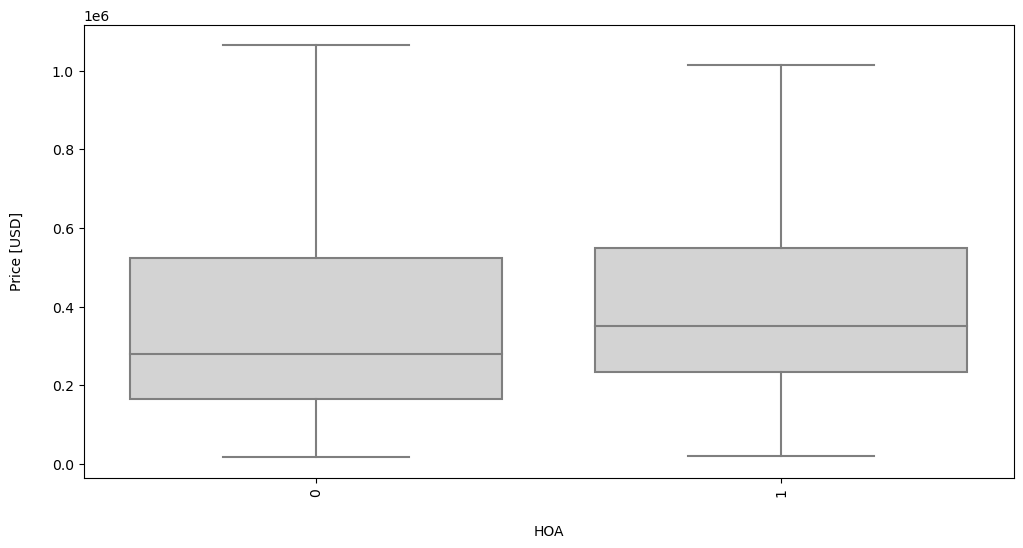

In [41]:
# Boxplot for HOA binary column 
#

plt.figure(figsize=(12, 6), dpi=100)
sns.boxplot(x='HOA', y='Price', data=train, color='lightgray', showfliers = False)
plt.ylabel('Price [USD]', labelpad=20)
plt.xlabel('HOA', labelpad=20)
plt.xticks(rotation=90);

### Number Days on Trulia

In [42]:
#Check the number of days on trulia of each house 


def clean_days_on_trulia(df):
    
    def search_trulia(listt):
        return [i for i in listt if 'Trulia' in i]
    
    df['Features'] = df['Features'].apply(lambda x: [element.strip() for element in x])
    
    trulia = [i for i in df['Features'].apply(lambda x: search_trulia(x))]
    
    df['trulia'] = pd.Series([item for sublist in trulia for item in (sublist or [np.nan])], index = df.index)
    
    df['trulia'] = df['trulia'].fillna('300')
    df['trulia'] = [extract_numerical_elements(i) for i in df['trulia']]
    
    #df['trulia'] = [df['trulia'].median() if i == 300.0 else i for i in df['trulia']]
    df['trulia'] = [np.nan if i == 300.0 else i for i in df['trulia']]
    df['trulia'] = df.groupby(['State'],dropna=False)['trulia'].apply(lambda x: x.fillna(x.median()))
    
    return df

In [43]:
train  = clean_days_on_trulia(train)
test = clean_days_on_trulia(test)

In [44]:
[i for i in test['trulia']]

[1.0,
 2.0,
 180.0,
 1.0,
 2.0,
 29.0,
 2.0,
 41.0,
 180.0,
 110.0,
 27.0,
 4.0,
 1.0,
 9.0,
 180.0,
 2.0,
 93.0,
 1.0,
 8.0,
 180.0,
 1.0,
 180.0,
 101.0,
 91.0,
 138.0,
 105.0,
 9.0,
 7.0,
 73.0,
 4.0,
 3.0,
 1.0,
 180.0,
 20.0,
 42.0,
 2.0,
 2.0,
 1.0,
 180.0,
 3.0,
 59.0,
 1.0,
 2.0,
 1.0,
 4.0,
 7.0,
 113.0,
 38.0,
 25.0,
 132.0,
 13.0,
 1.0,
 180.0,
 3.0,
 87.0,
 16.0,
 15.0,
 180.0,
 2.0,
 81.0,
 10.0,
 14.0,
 113.0,
 9.0,
 1.0,
 112.0,
 35.0,
 35.0,
 24.0,
 17.0,
 8.0,
 1.0,
 180.0,
 48.0,
 1.0,
 106.0,
 83.0,
 6.0,
 40.0,
 5.0,
 66.0,
 180.0,
 2.0,
 13.0,
 57.0,
 126.0,
 7.0,
 43.0,
 2.0,
 6.0,
 2.0,
 2.0,
 1.0,
 56.0,
 1.0,
 3.0,
 82.0,
 64.0,
 122.0,
 13.0,
 1.0,
 1.0,
 2.0,
 14.0,
 23.0,
 42.0,
 3.0,
 1.0,
 2.0,
 7.0,
 1.0,
 1.0,
 124.0,
 2.0,
 1.0,
 35.0,
 94.0,
 24.0,
 64.0,
 66.0,
 2.0,
 6.0,
 83.0,
 39.0,
 180.0,
 7.0,
 6.0,
 1.0,
 84.0,
 16.0,
 72.0,
 2.0,
 132.0,
 30.0,
 150.0,
 23.0,
 23.0,
 3.0,
 1.0,
 3.0,
 3.0,
 169.0,
 2.0,
 92.0,
 106.0,
 71.0,
 180.0,
 97.0,
 2

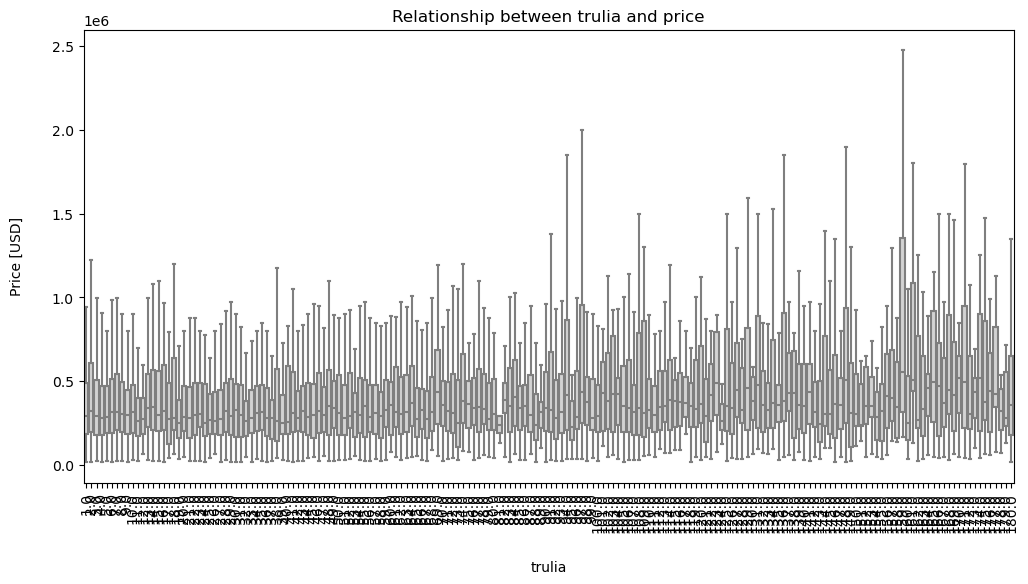

In [45]:
# Inspect relationship between number days on trulia and price in the training data
# Again, this feature should not very helpful to predict house price 

plt.figure(figsize=(12, 6), dpi=100)
sns.boxplot(x='trulia', y='Price', data=train, color='lightgray', showfliers = False)
plt.ylabel('Price [USD]', labelpad=20)
plt.xlabel('trulia', labelpad=20)
plt.xticks(rotation=90)
plt.title('Relationship between trulia and price');

### Parking Spaces

In [46]:
# Create column for the number of parking space

def clean_parking_spaces(df):
    
    def search_parking_spaces(listt):
        return [i for i in listt if 'Parking Spaces' in i]
    
    df['Features'] = df['Features'].apply(lambda x: [element.strip() for element in x])
    
    parking_spaces = [i for i in df['Features'].apply(lambda x: search_parking_spaces(x))]
    
    df['parking_spaces'] = pd.Series([item for sublist in parking_spaces for item in (sublist or [np.nan])], index = df.index)
    
    df['parking_spaces'] = df['parking_spaces'].fillna('300')
    df['parking_spaces'] = [extract_numerical_elements(i) for i in df['parking_spaces']]
    df['parking_spaces'] = [0.0 if i == 300.0 else i for i in df['parking_spaces']]
    
    return df

In [47]:
train = clean_parking_spaces(train)
test = clean_parking_spaces(test)

In [48]:
test['parking_spaces']

Uniq Id
dfba9eb1dadb1f143d60559f55cec6e5    1.0
7d028c98db434a41fe331569d291cdd8    0.0
2e7f38cdbf0a487177cdda0f5491f9b3    0.0
143f5b380282138db0ff30d7478f4634    2.0
e6ff96628ba6c4a1f3453d68f1df8e75    2.0
                                   ... 
42a9f18319ed4a75e2f9debed35025cf    0.0
74e3a157d4fae21e79fe89a84dad12d1    1.0
f5f23a3abd41102b3fa6e73b04b8fc29    0.0
a32a07ef179d144ca75cb35b2157b4a1    0.0
9812935d844b5696c2a83ad08c24fc8a    0.0
Name: parking_spaces, Length: 5000, dtype: float64

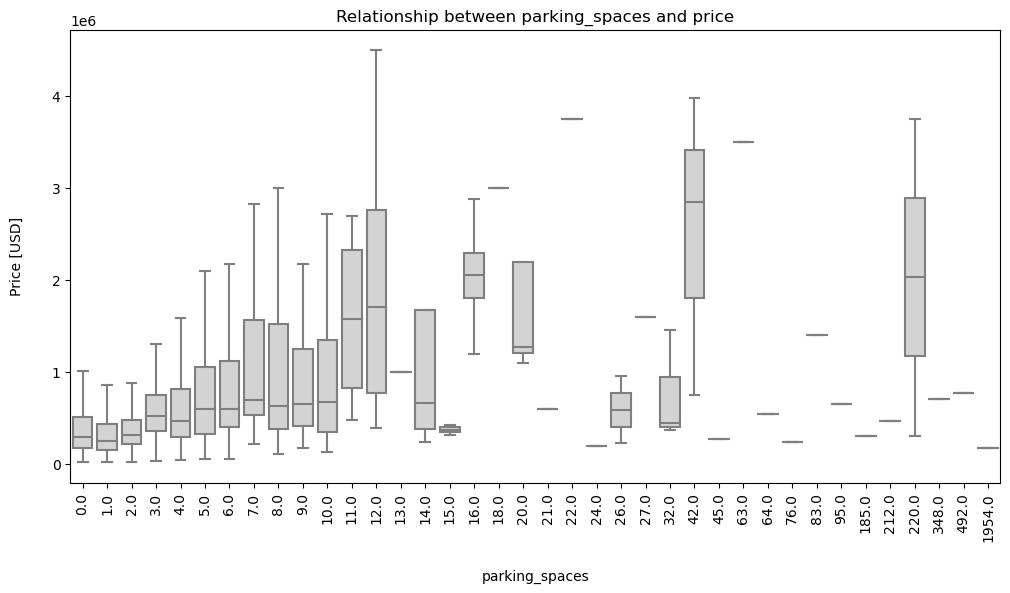

In [49]:
# Inspect relationship between parking_spaces and price in the training data
# This feature seems to have some predictive power up to a certain point (12 spaces)

plt.figure(figsize=(12, 6), dpi=100)
sns.boxplot(x='parking_spaces', y='Price', data=train, color='lightgray', showfliers = False)
plt.ylabel('Price [USD]', labelpad=20)
plt.xlabel('parking_spaces', labelpad=20)
plt.xticks(rotation=90)
plt.title('Relationship between parking_spaces and price');

### Year Updated

In [50]:
# Create feature column with the year the house has been updated

def clean_year_updated(df):
    
    def search_year_updated(listt):
        return [i for i in listt if 'Year Updated:' in i]
    
    
    df['Features'] = df['Features'].apply(lambda x: [element.strip() for element in x])
    
    year_updated = [i for i in df['Features'].apply(lambda x: search_year_updated(x))]
    
    df['year_updated'] = pd.Series([item for sublist in year_updated for item in (sublist or [np.nan])], index = df.index)
    
    df['year_updated'] = df['year_updated'].fillna('300.0')
    df['year_updated'] = [extract_numerical_elements(i) for i in df['year_updated']]
    df['year_updated'] = [np.nan if i == 300.0 else i for i in df['year_updated']]
    df['year_updated'] = df.groupby(['State'],dropna=False)['year_updated'].apply(lambda x: x.fillna(x.median()))
    
    return df

In [51]:
train = clean_year_updated(train)
test = clean_year_updated(test)

In [52]:
[i for i in test['year_updated']]

[1940.0,
 1991.0,
 2006.0,
 1995.0,
 2006.0,
 1995.0,
 2011.0,
 2014.0,
 1992.0,
 2006.0,
 2011.0,
 2012.0,
 2019.0,
 1971.0,
 1940.0,
 1910.0,
 1994.5,
 2002.0,
 2014.0,
 1956.0,
 1910.0,
 1979.0,
 2016.5,
 2005.0,
 1971.0,
 1950.0,
 1954.0,
 1940.0,
 2006.0,
 2004.0,
 1983.0,
 1999.5,
 2016.5,
 2014.5,
 1992.0,
 1959.0,
 1968.0,
 1934.0,
 1968.0,
 2011.0,
 2014.5,
 2000.0,
 1983.0,
 1985.0,
 1994.0,
 2015.0,
 2014.0,
 2002.0,
 1960.0,
 2006.0,
 1954.0,
 2015.0,
 1997.0,
 1997.0,
 2016.5,
 1968.0,
 2011.0,
 1964.5,
 1940.0,
 1935.0,
 1999.5,
 2017.0,
 2006.0,
 2014.0,
 1949.0,
 2000.0,
 1995.0,
 2006.0,
 1988.0,
 2011.0,
 1997.0,
 2009.0,
 2015.0,
 2016.0,
 1949.0,
 1999.5,
 1985.0,
 1999.0,
 2014.5,
 1995.0,
 1977.0,
 2010.5,
 2002.0,
 2010.5,
 1942.0,
 1983.0,
 1974.0,
 1999.0,
 1940.0,
 2019.0,
 1940.0,
 2014.5,
 1941.0,
 1971.0,
 1940.0,
 2010.5,
 1987.0,
 2011.0,
 2014.5,
 1974.0,
 2002.0,
 2011.0,
 2002.0,
 1968.0,
 2018.0,
 1995.0,
 2011.0,
 1989.0,
 2014.0,
 1974.0,
 1987.0,
 

### Heating Type

In [53]:
# Create feature column for heating type

def clean_heating(df):
    
    def search_heating(listt):
        return [i for i in listt if 'Heating:' in i]
    
    
    df['Features'] = df['Features'].apply(lambda x: [element.strip() for element in x])
    
    heating = [i for i in df['Features'].apply(lambda x: search_heating(x))]
    
    
    df['heating'] = pd.Series([item for sublist in heating for item in (sublist or [np.nan])], index = df.index)
    
    df['heating'] = df['heating'].fillna('Unvailable')
    df['heating'] = [i.split(':')[1].strip() if i != 'Unvailable' else  i for i in df['heating']]
    
    df['heating'] = [np.nan if i ==  'Unvailable' else i for i in df['heating']]
    
    return df

In [54]:
train = clean_heating(train)
test = clean_heating(test)

In [55]:
test['heating']

Uniq Id
dfba9eb1dadb1f143d60559f55cec6e5           NaN
7d028c98db434a41fe331569d291cdd8    Forced Air
2e7f38cdbf0a487177cdda0f5491f9b3    Forced Air
143f5b380282138db0ff30d7478f4634    Forced Air
e6ff96628ba6c4a1f3453d68f1df8e75    Forced Air
                                       ...    
42a9f18319ed4a75e2f9debed35025cf           NaN
74e3a157d4fae21e79fe89a84dad12d1    Forced Air
f5f23a3abd41102b3fa6e73b04b8fc29           NaN
a32a07ef179d144ca75cb35b2157b4a1           NaN
9812935d844b5696c2a83ad08c24fc8a       Radiant
Name: heating, Length: 5000, dtype: object

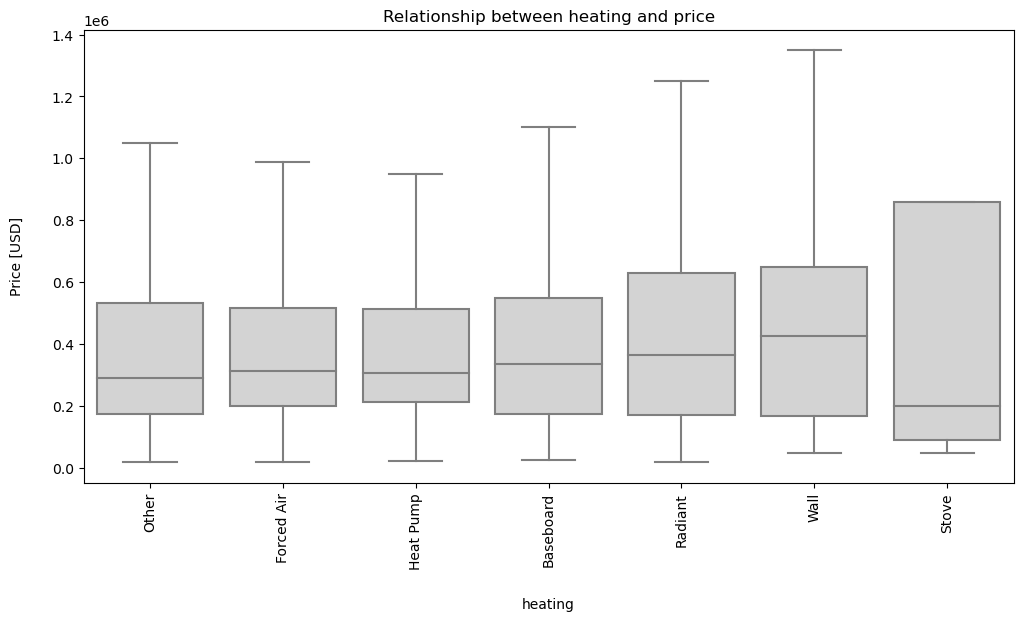

In [56]:
# Inspect relationship between heating and price in the training data
plt.figure(figsize=(12, 6), dpi=100)
sns.boxplot(x='heating', y='Price', data=train, color='lightgray', showfliers = False)
plt.ylabel('Price [USD]', labelpad=20)
plt.xlabel('heating', labelpad=20)
plt.xticks(rotation=90)
plt.title('Relationship between heating and price');

### Heating Fuel Type

In [57]:
#create feature column for type of heating fuel

def clean_heating_fuel(df):
    
    def search_heating_fuel(listt):
        return [i for i in listt if 'Heating Fuel:' in i]
    
    
    df['Features'] = df['Features'].apply(lambda x: [element.strip() for element in x])
    
    heating_fuel = [i for i in df['Features'].apply(lambda x: search_heating_fuel(x))]
    
    
    df['heating_fuel'] = pd.Series([item for sublist in heating_fuel for item in (sublist or [np.nan])], index = df.index)
    
    df['heating_fuel'] = df['heating_fuel'].fillna('Unvailable')
    df['heating_fuel'] = [i.split(':')[1].strip() if i != 'Unvailable' else  i for i in df['heating_fuel']]
    
    df['heating_fuel'] = [np.nan if i ==  'Unvailable' else i for i in df['heating_fuel']]
    
    return df

In [58]:
train = clean_heating_fuel(train)
test = clean_heating_fuel(test)

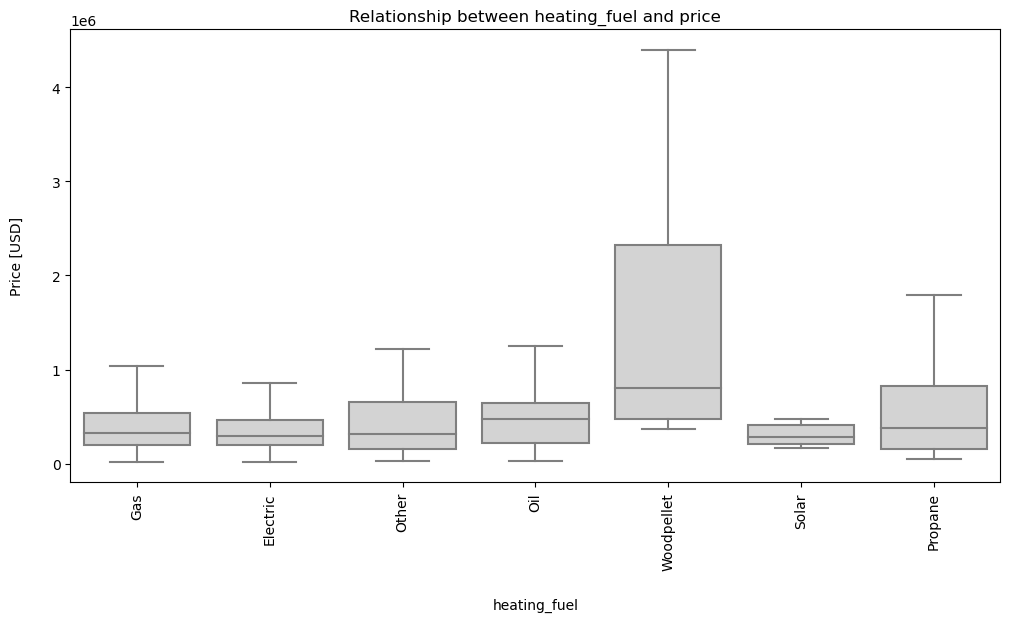

In [59]:
# Inspect relationship between heating fuel and price in the training data

plt.figure(figsize=(12, 6), dpi=100)
sns.boxplot(x='heating_fuel', y='Price', data=train, color='lightgray', showfliers = False)
plt.ylabel('Price [USD]', labelpad=20)
plt.xlabel('heating_fuel', labelpad=20)
plt.xticks(rotation=90)
plt.title('Relationship between heating_fuel and price');

### Loop throug Important features to create new binary columns 

In [60]:
# List of potentially useful features extracted from the house with the maximum number of features (as seen before)

list_important_features = ['Great Views','Fireplace','Furnished','Air Conditioning', 'Skylight', 'Jetted Bath Tub', 
                            'Rv Parking', 'Basement', 'Attic', 'Security System', 
                          'Fitness Center', 'Basketball Court', 'Tennis Court', 'Sport Court', 'Doorman',
                          'Garden', 'Pool', 'Hot Tub or Spa', 'Sauna', 'Pond', 'Waterfront','Double Paned Windows',
                          'Vaulted Ceiling','Barbeque Area','Elevator','Gated Entry','Intercom','Ranch Architecture',
                          'Patio','Porch','Deck','Lawn','Greenhouse','Dock','Sprinkler System','Disabled Access']

In [61]:
def loop_throug_features(df,list_important_features):
    '''
    input: a pandas dataframe and a list
    output: a dataframe
    
    This function loops through the list of binary features and created columns of zeros and ones
    corresponding to the presence or not of the feature for each particular house.
    '''
    for i in list_important_features:
        
        def create_feature(df):

            def search_feature(listt):
                return [elem for elem in listt if i in elem]

            df['Features'] = df['Features'].apply(lambda x: [element.strip() for element in x])

            feature = [i for i in df['Features'].apply(lambda x: search_feature(x))]

            df[f'{i}'] = pd.Series([item for sublist in feature for item in (sublist or [np.nan])], index = df.index)

            df[f'{i}'] = [i for i in df[f'{i}'].where(df[f'{i}'].isnull(), 1).fillna(0).astype(int)]
    
            return df
    
        df =  create_feature(df)
        
    return df

In [62]:
train = loop_throug_features(train,list_important_features)
test = loop_throug_features(test,list_important_features)

### Relationship between binary features and price

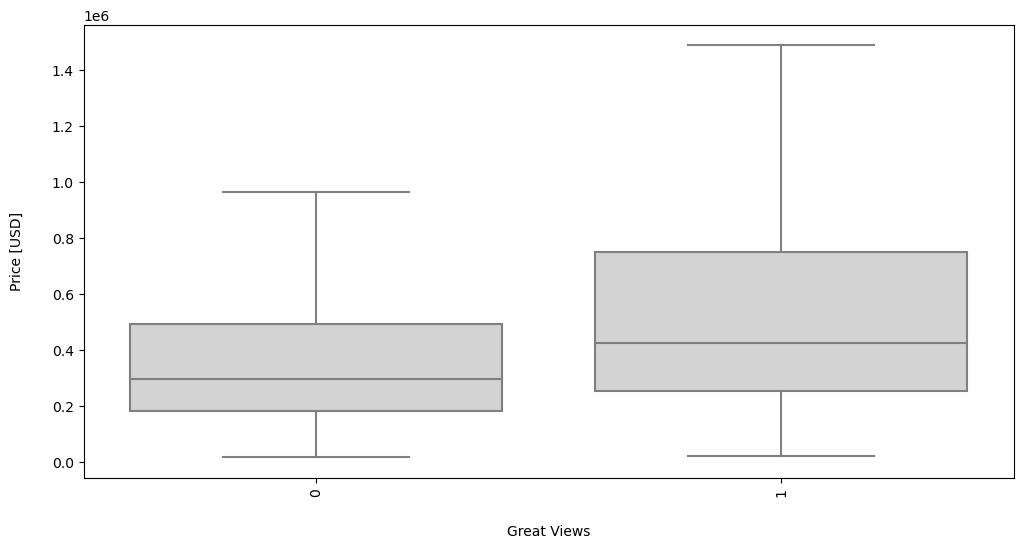

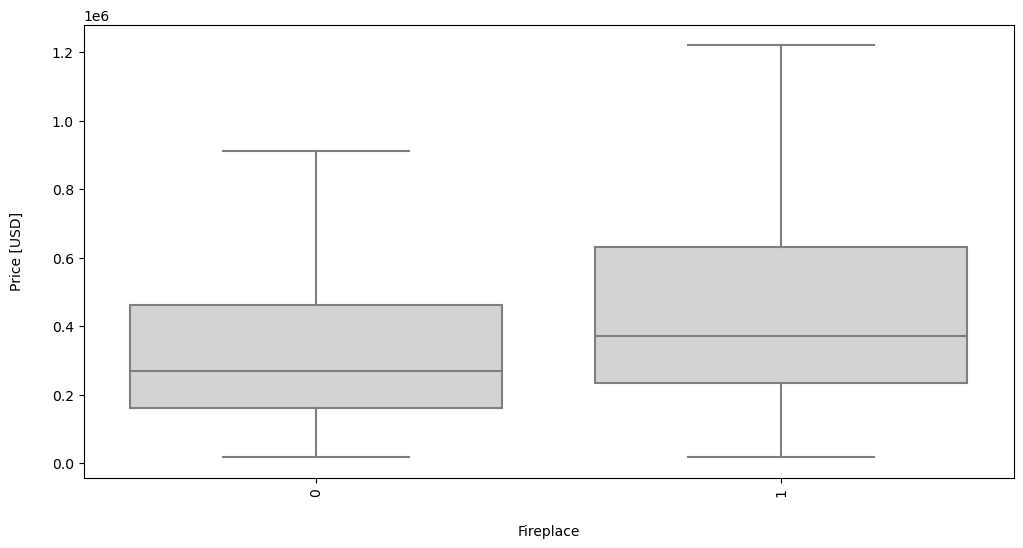

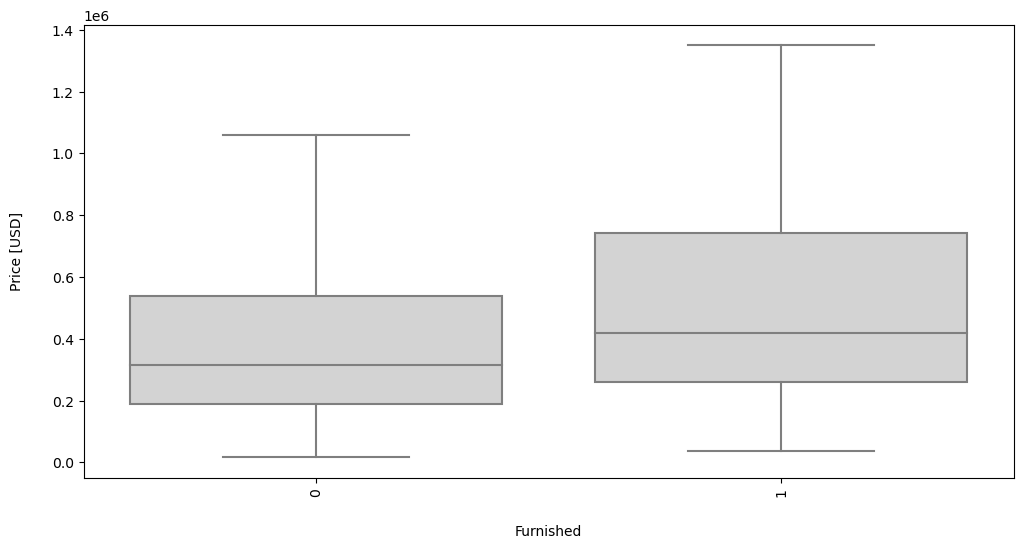

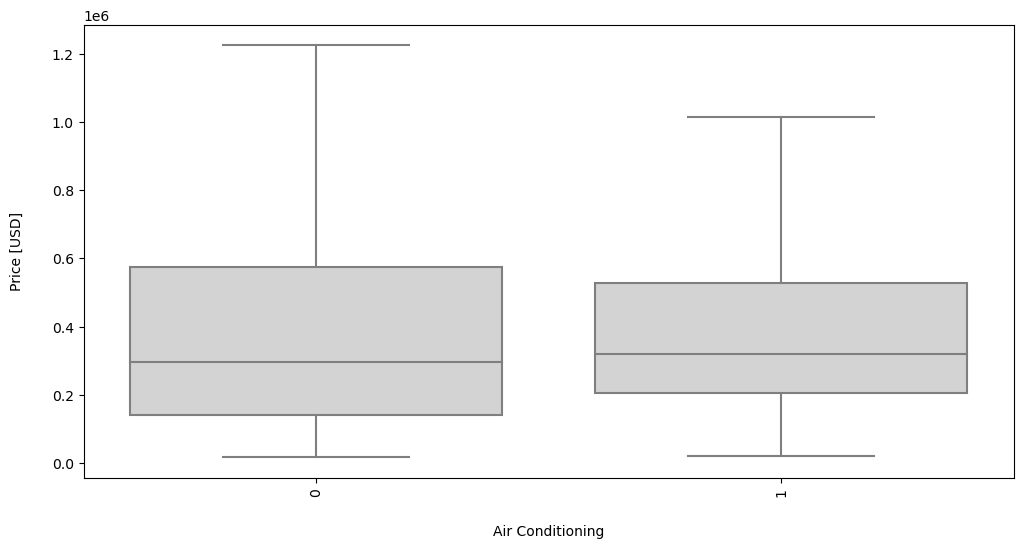

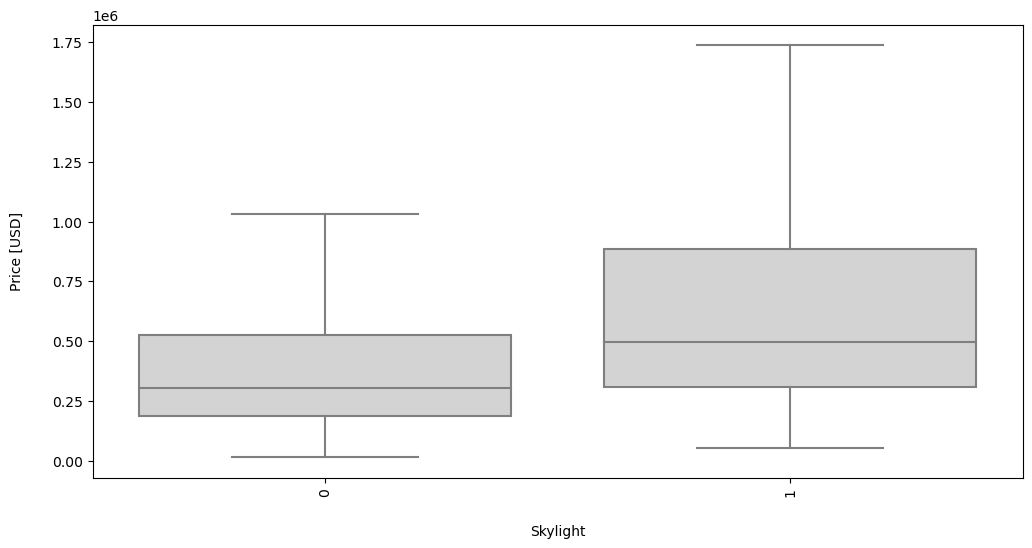

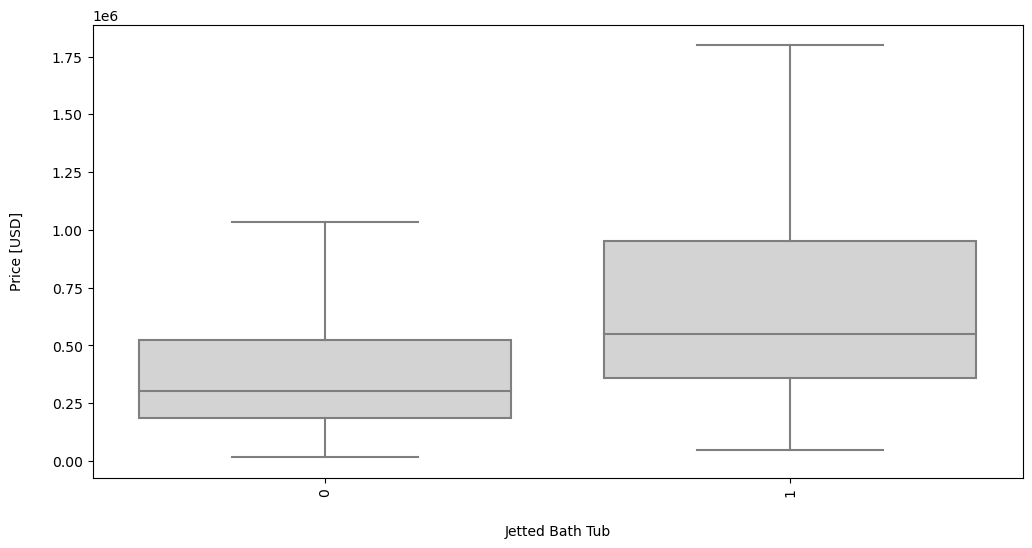

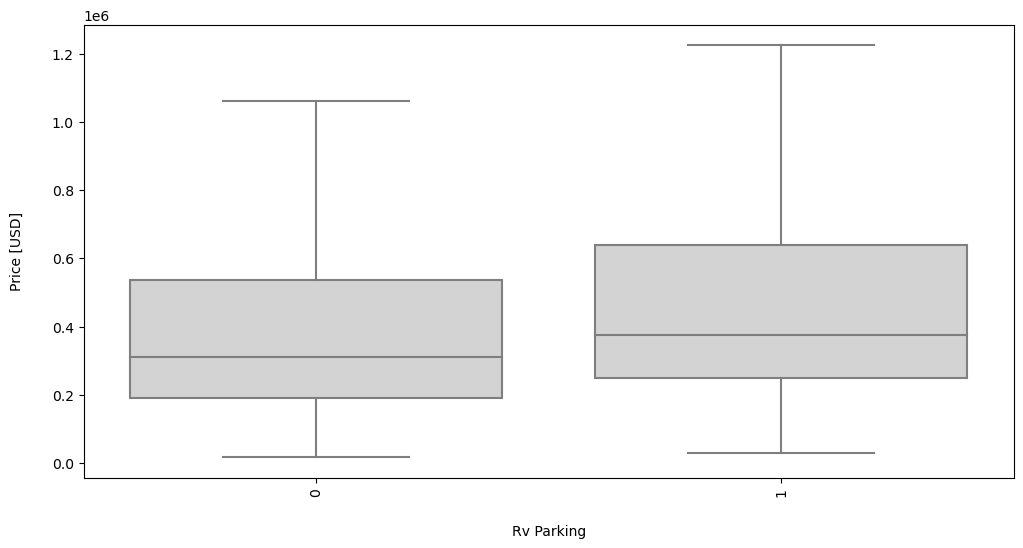

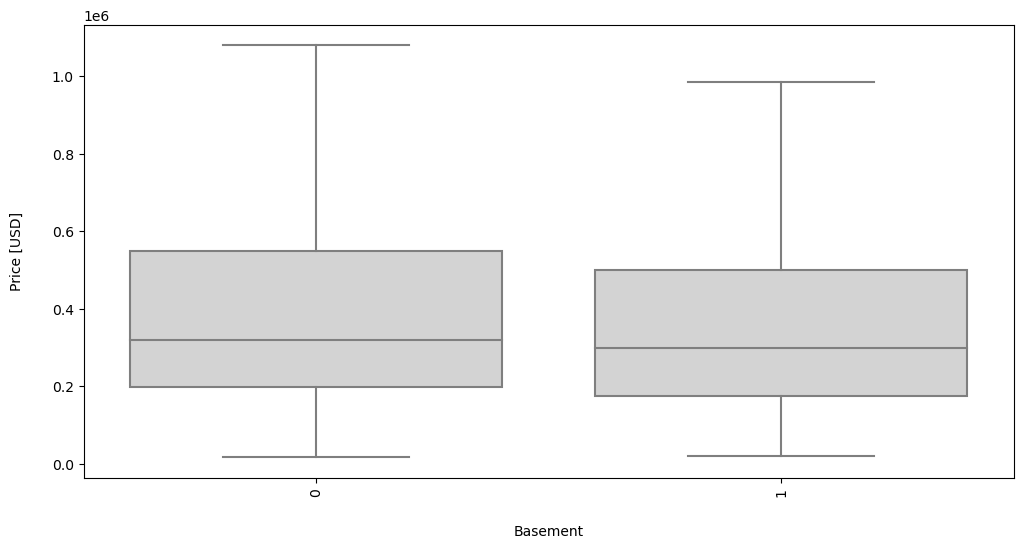

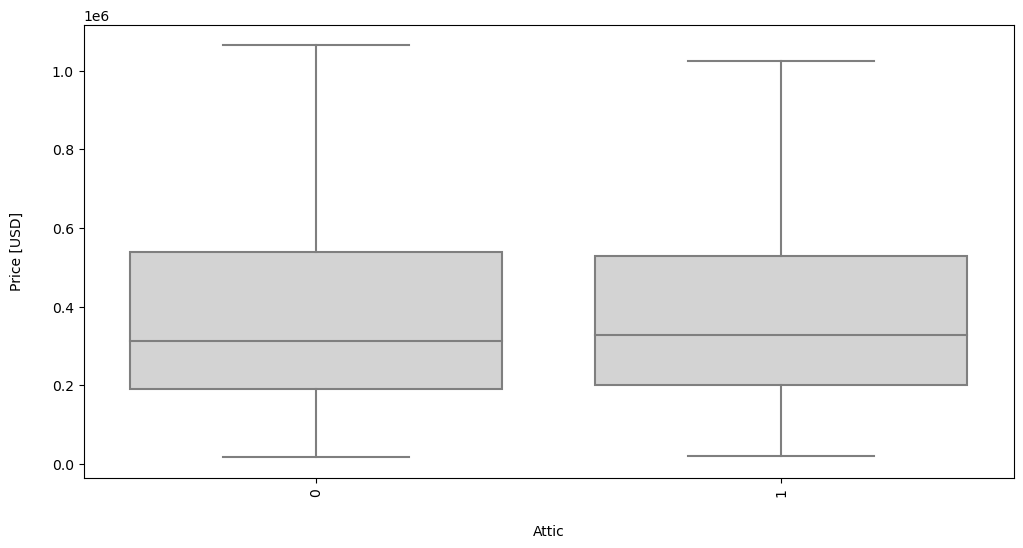

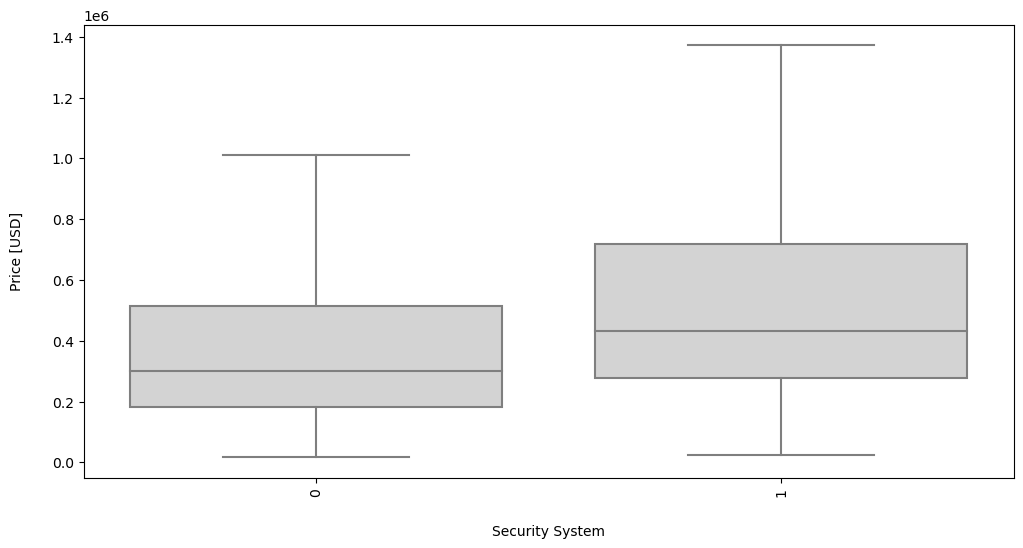

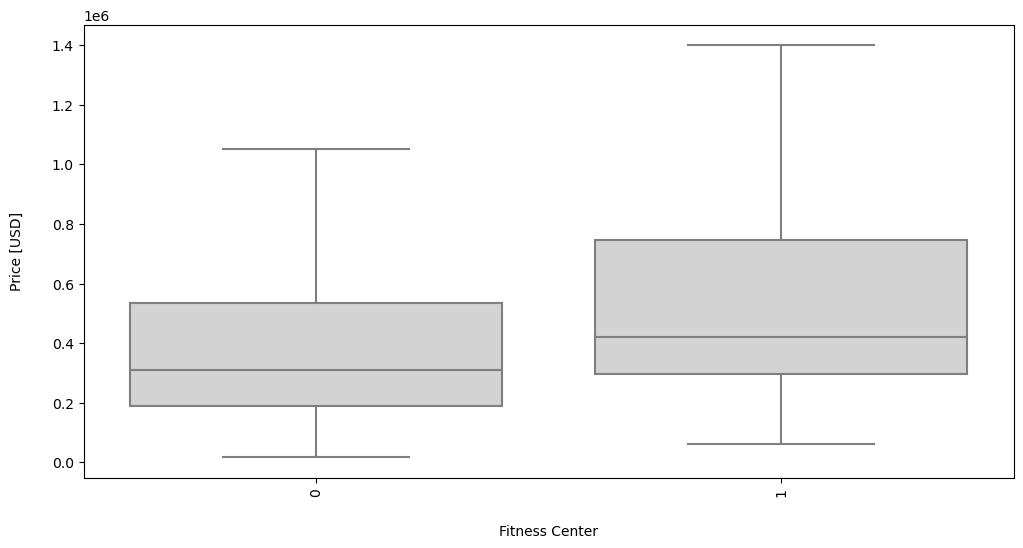

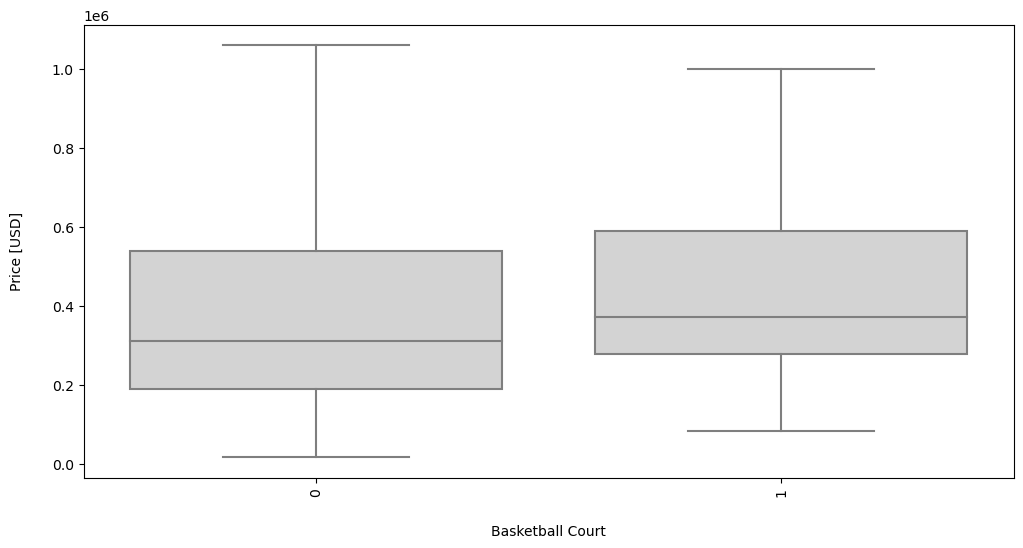

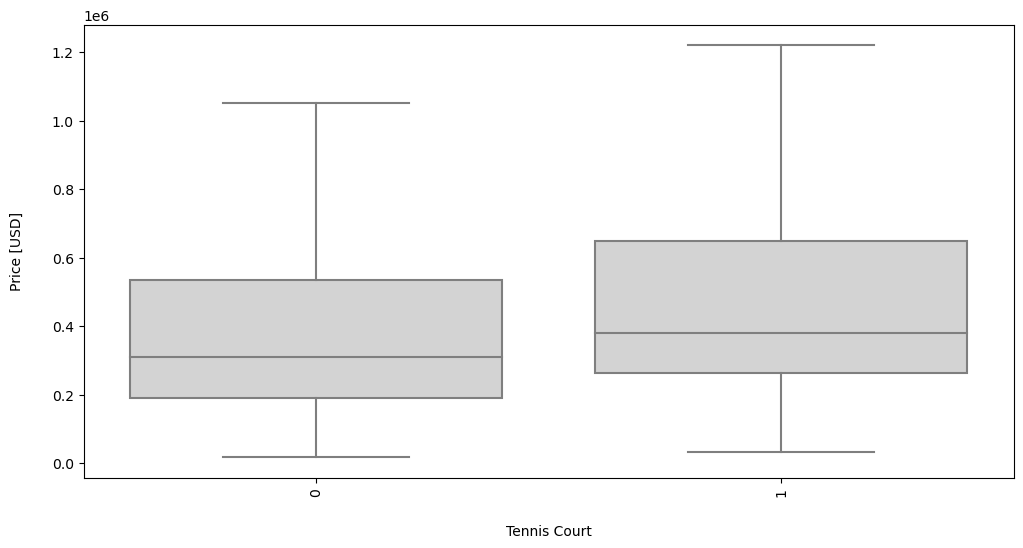

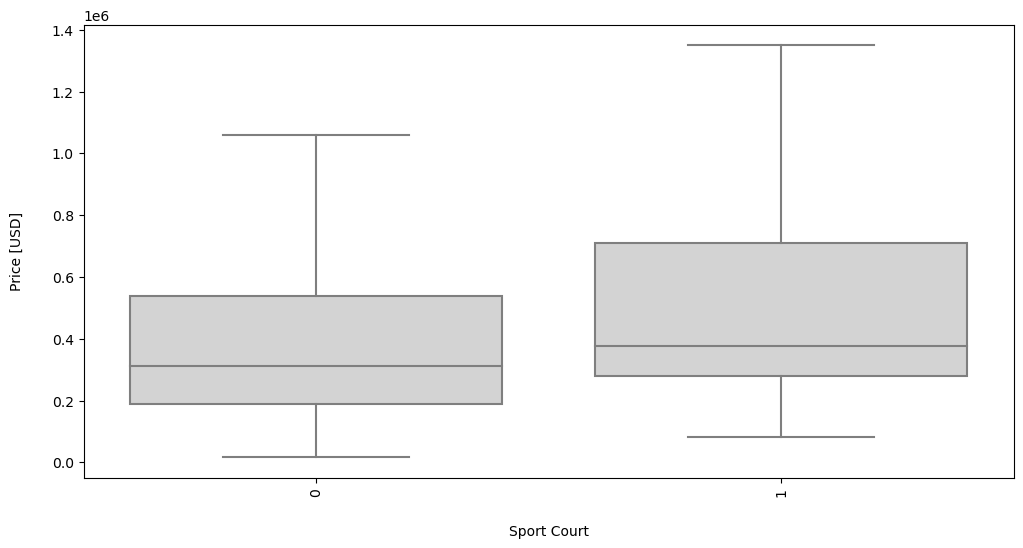

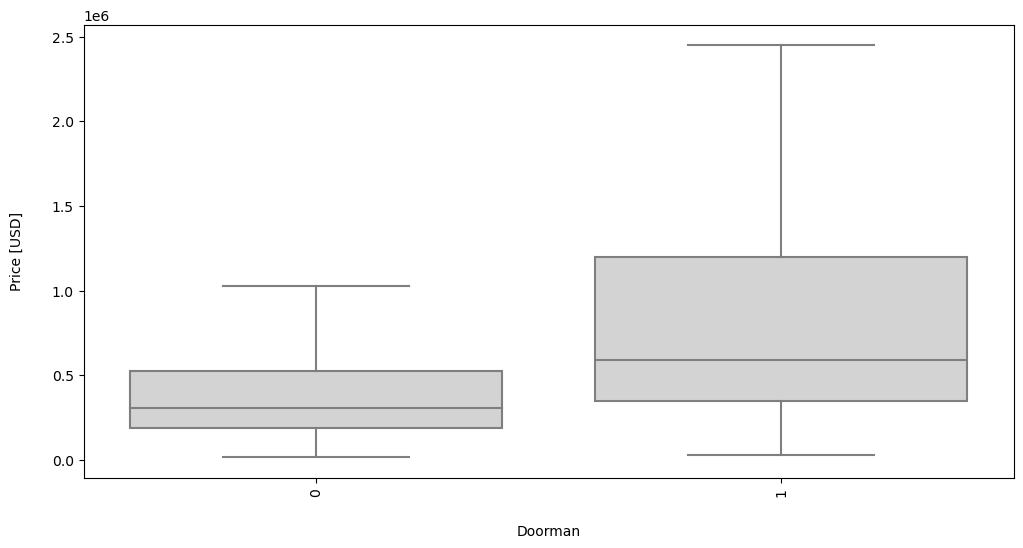

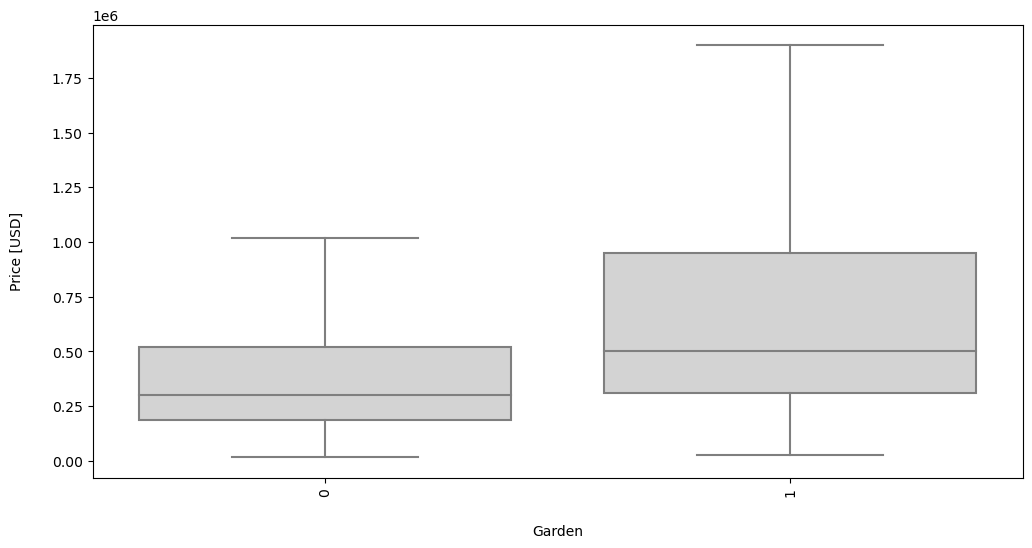

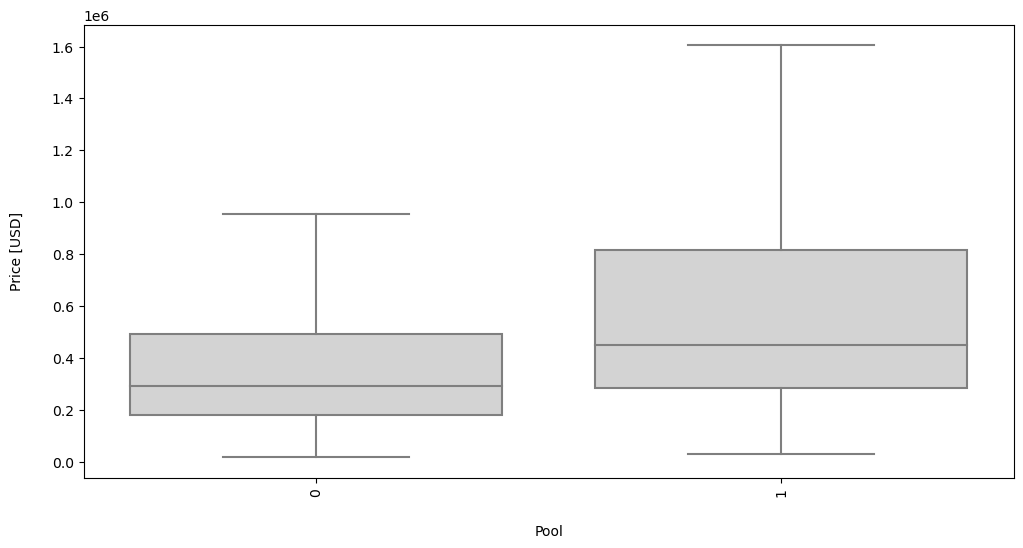

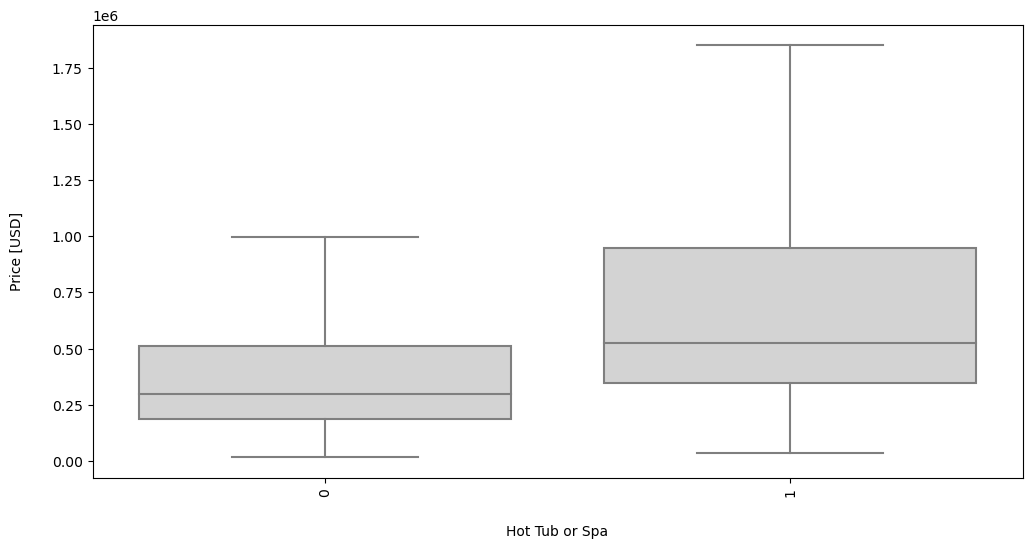

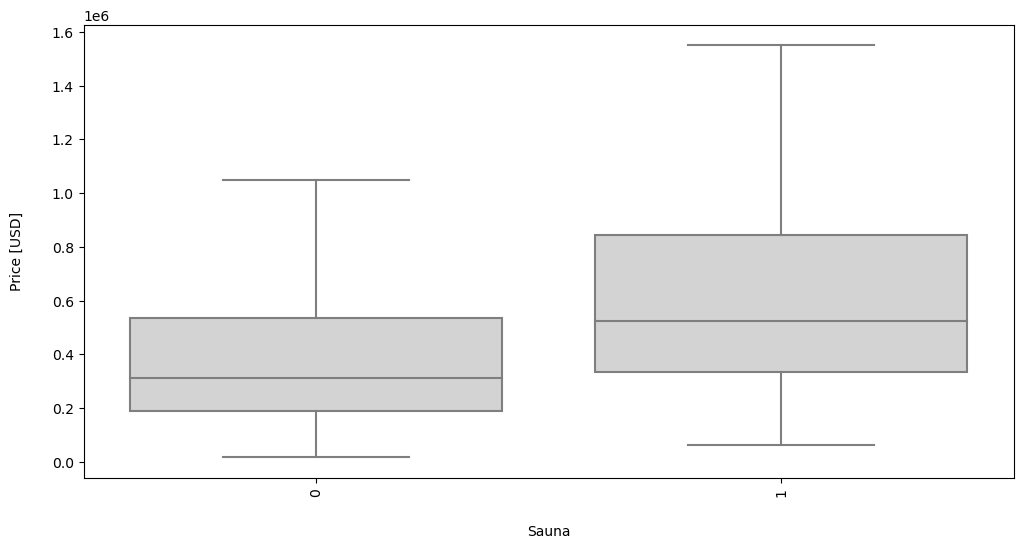

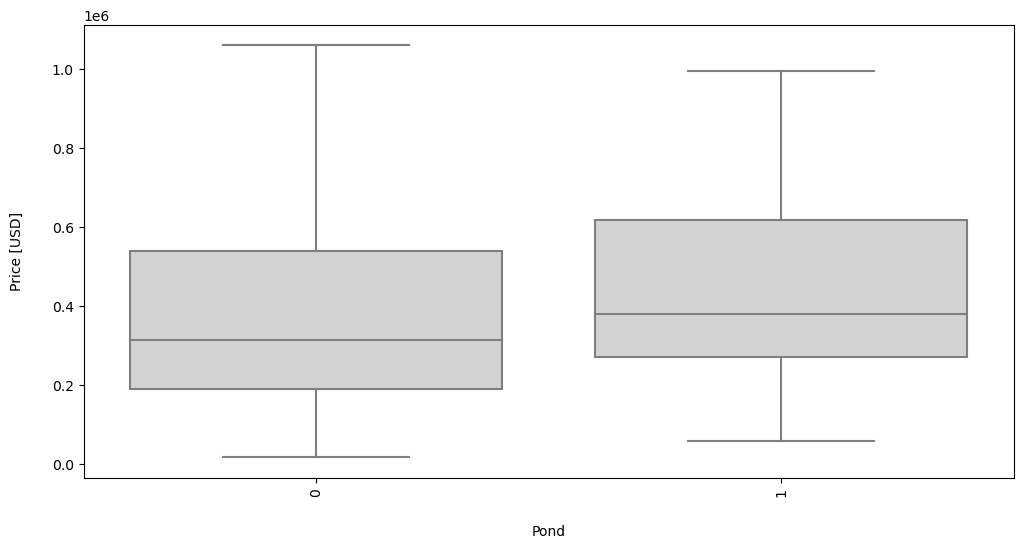

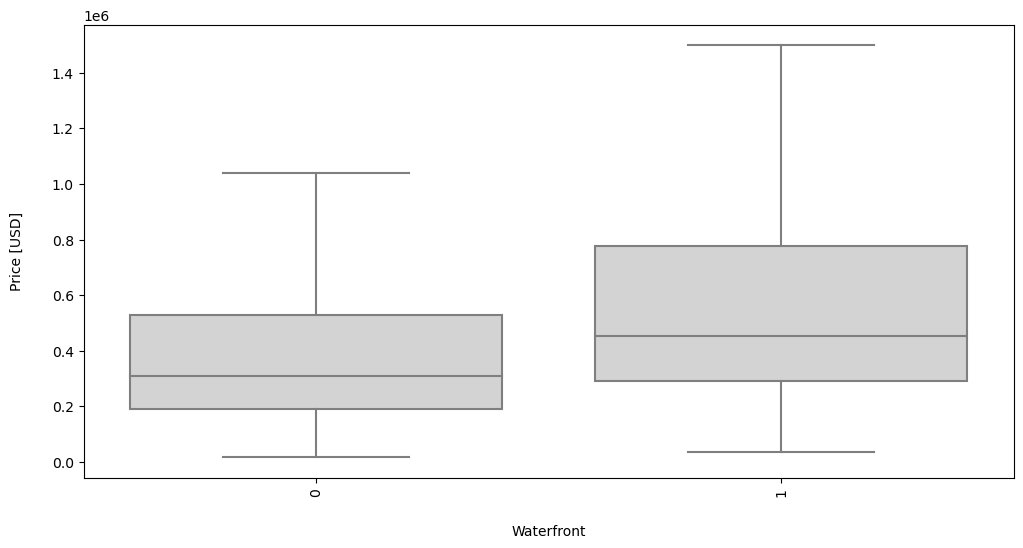

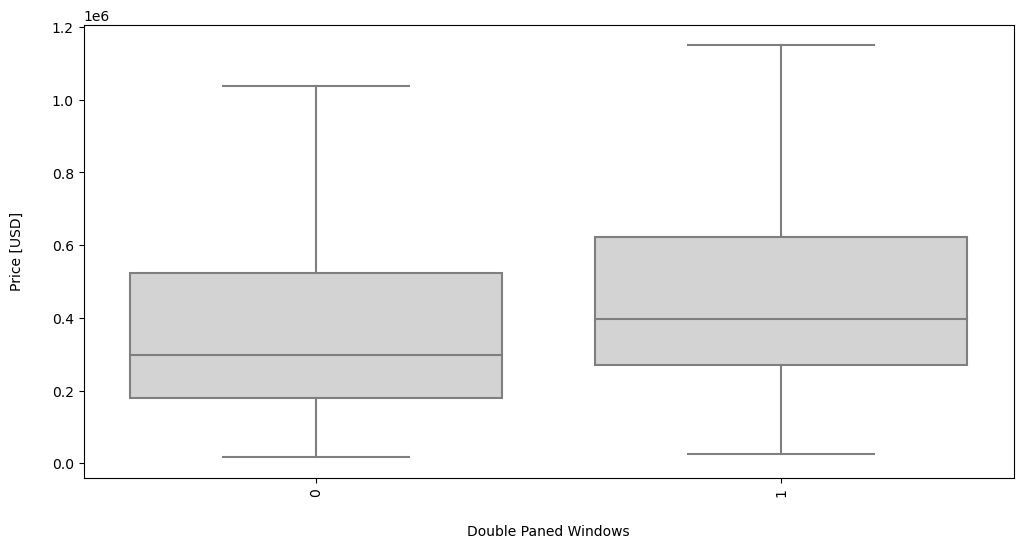

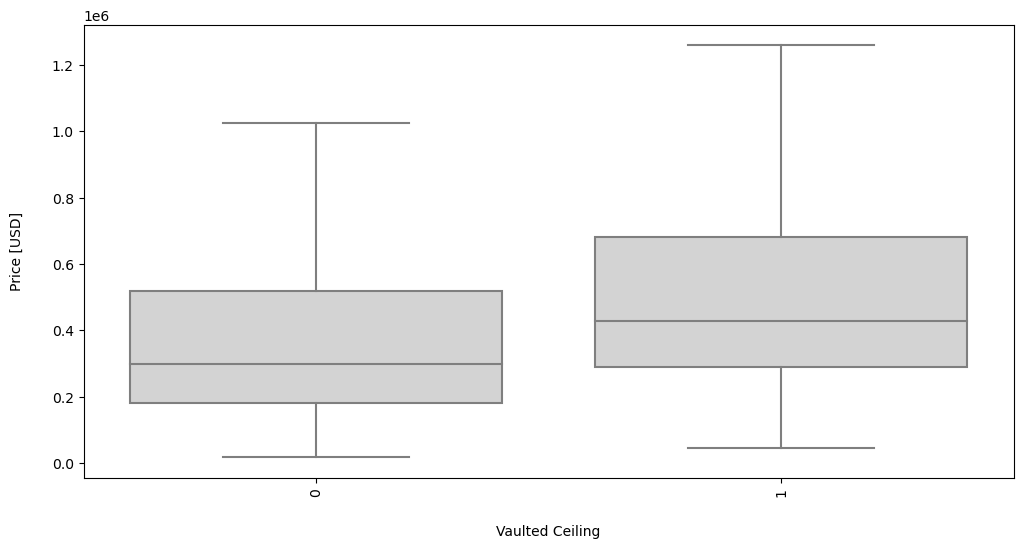

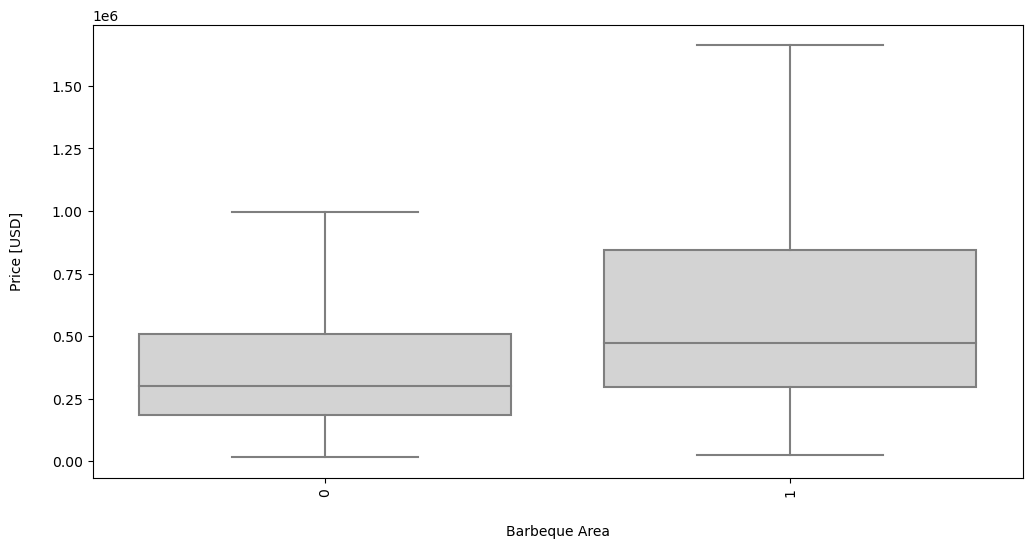

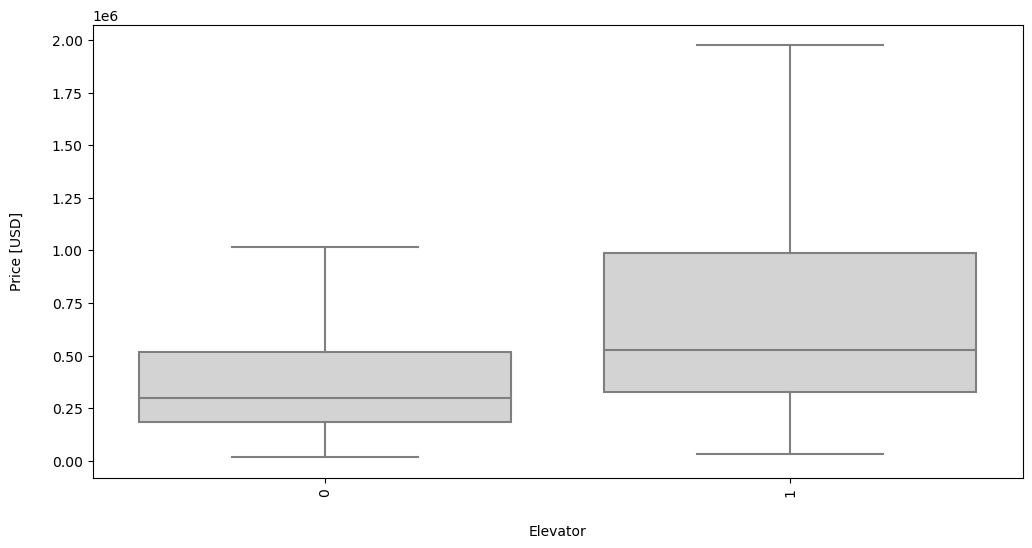

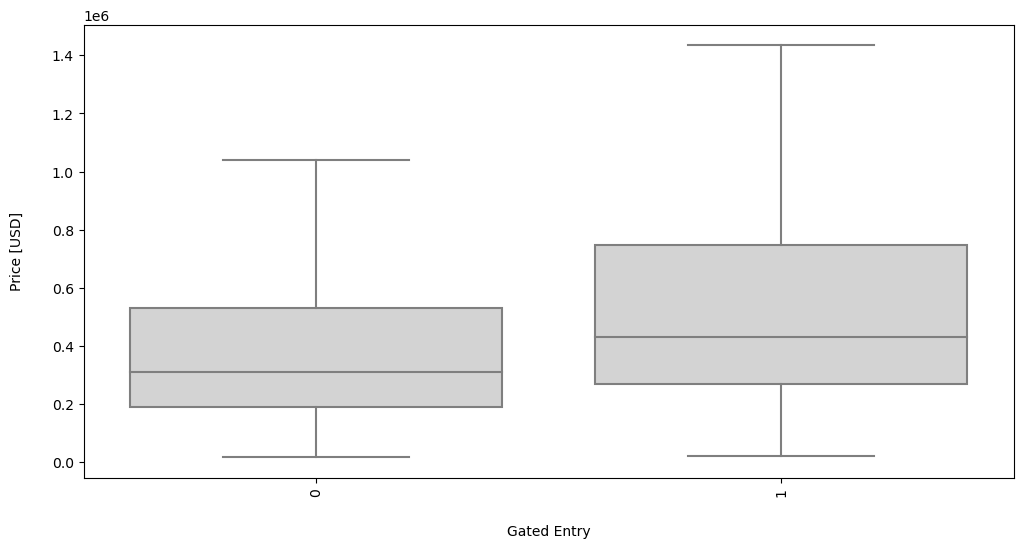

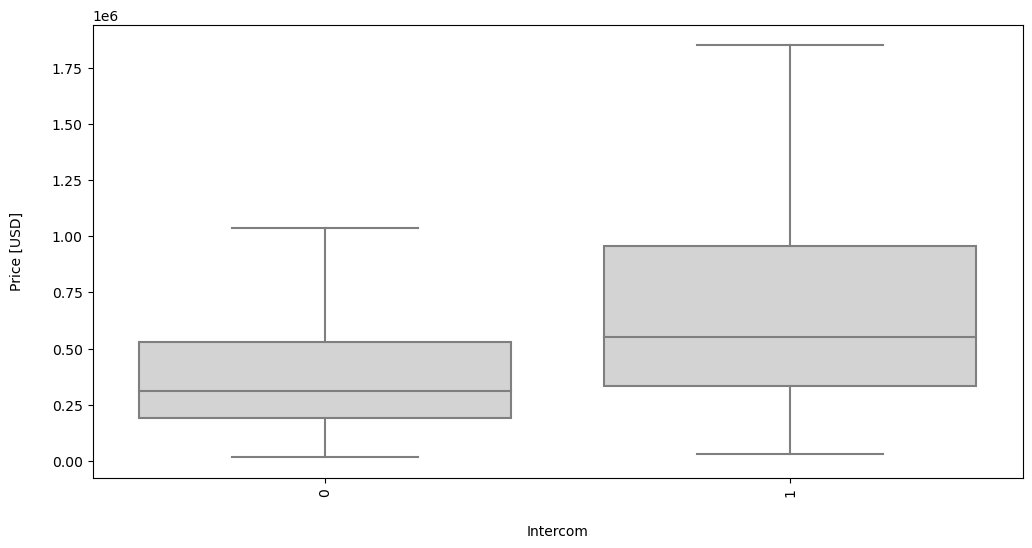

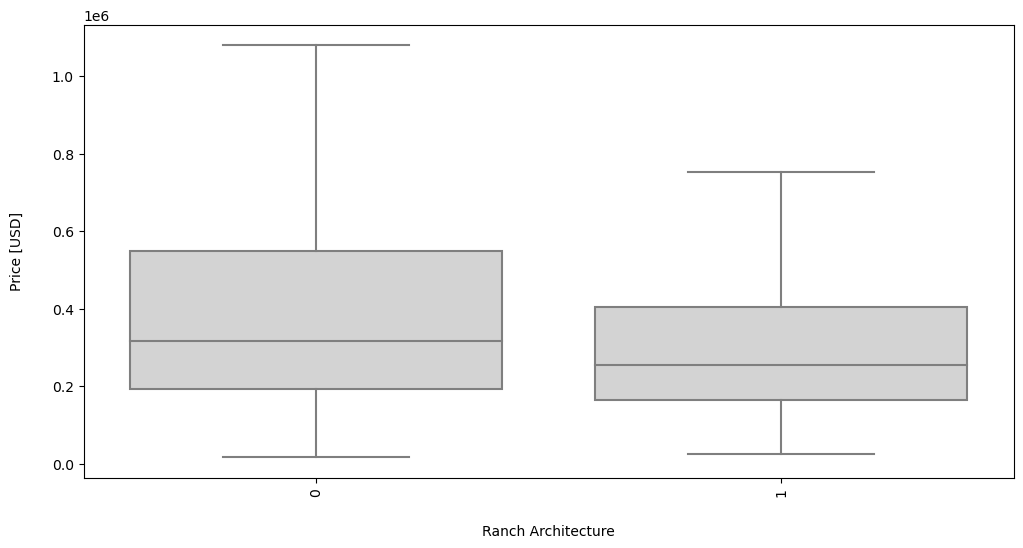

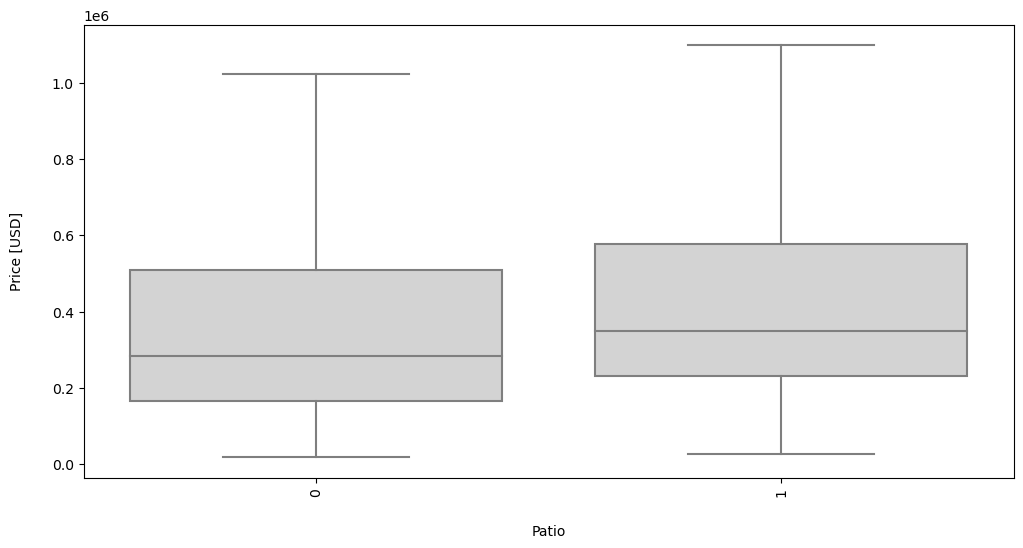

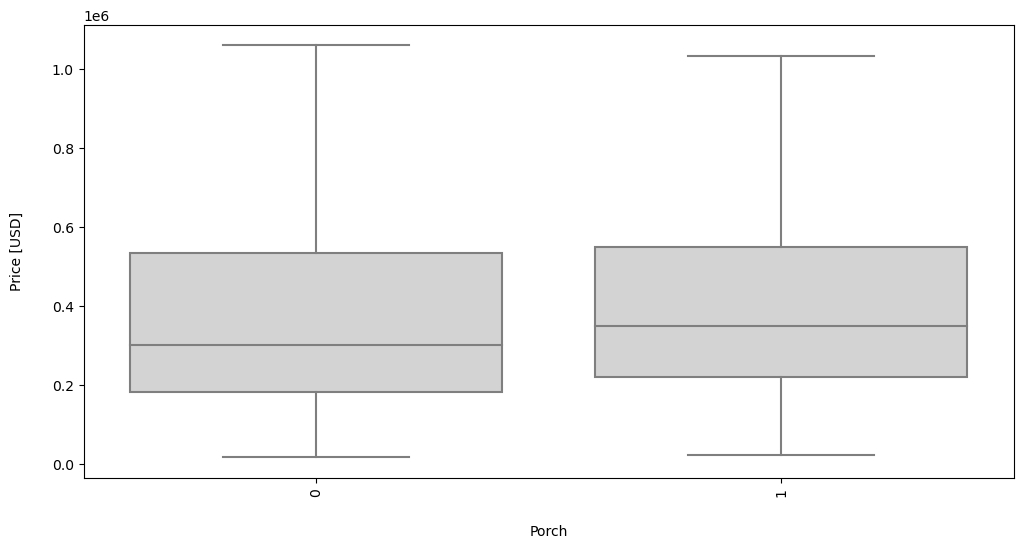

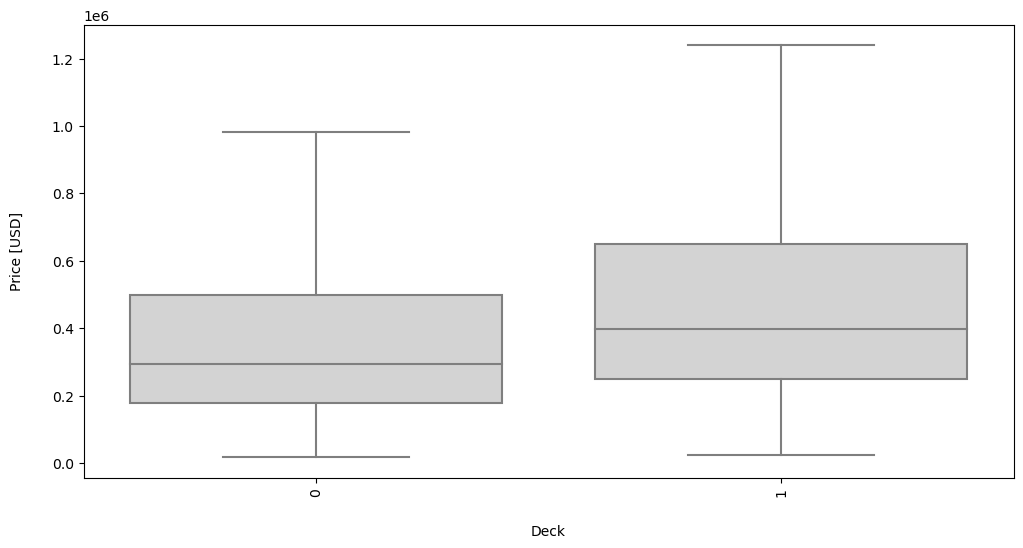

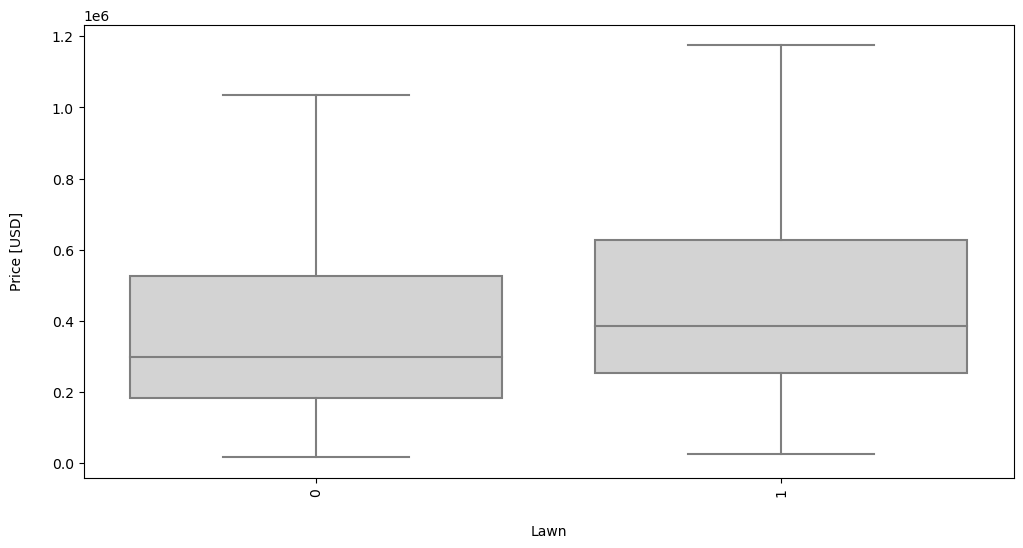

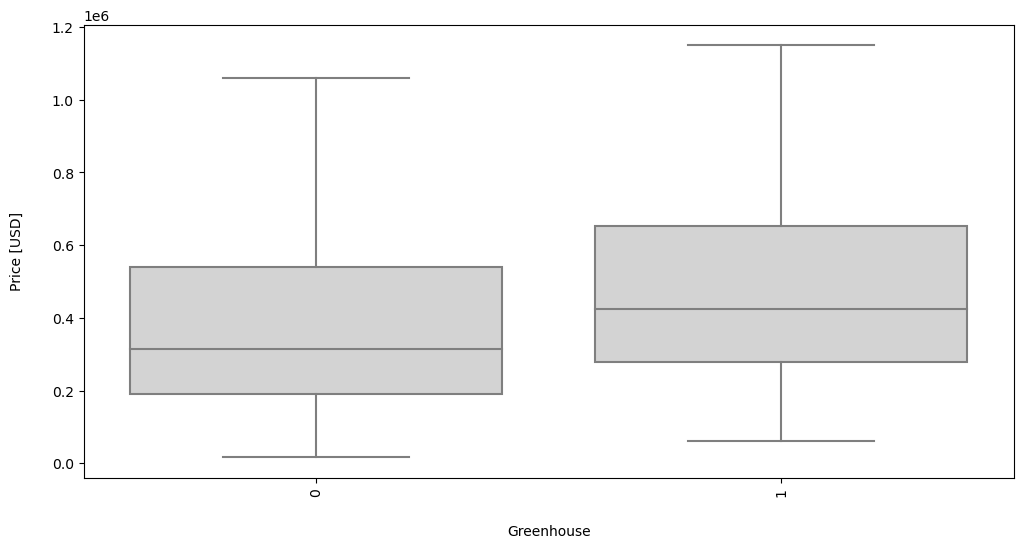

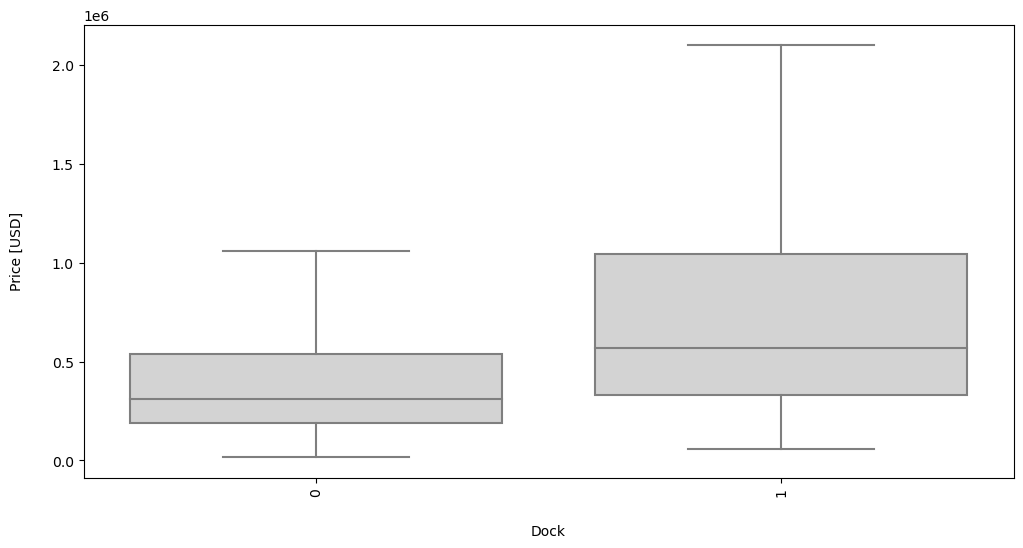

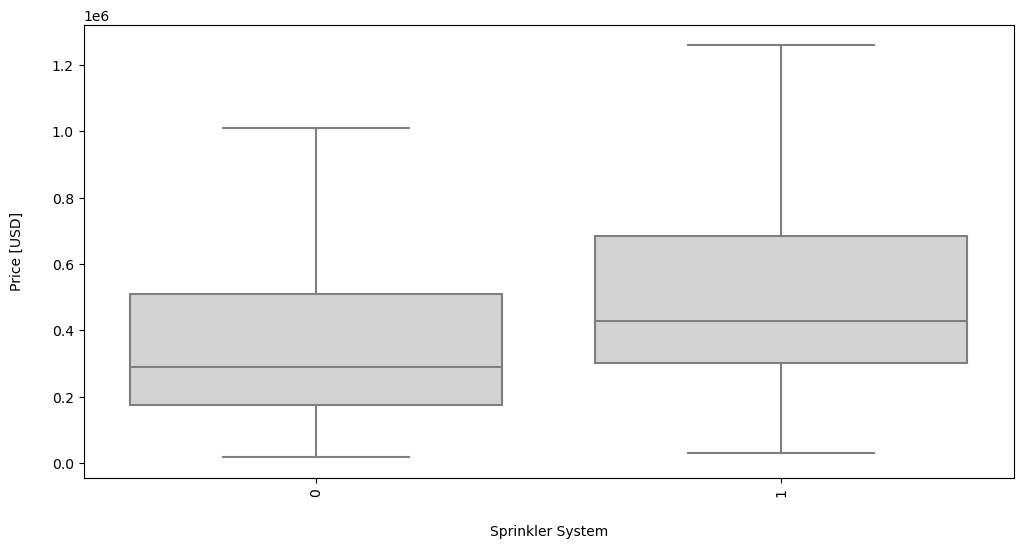

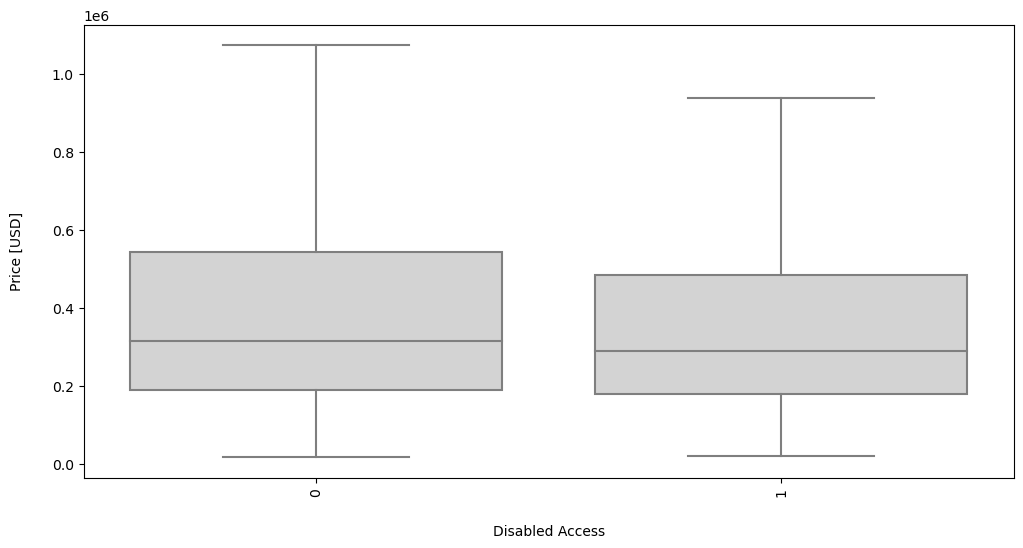

In [63]:
# This cell loops trough a list of binary features (the same as above) and create boxplots from the relation 
# between the feature and the price.

# run this to ignore the warning
import warnings
warnings.filterwarnings("ignore")


binary_features = [
                    'Great Views', 'Fireplace', 'Furnished', 'Air Conditioning', 'Skylight',
                    'Jetted Bath Tub', 'Rv Parking', 'Basement', 'Attic', 'Security System',
                    'Fitness Center', 'Basketball Court', 'Tennis Court', 'Sport Court',
                    'Doorman', 'Garden', 'Pool', 'Hot Tub or Spa', 'Sauna', 'Pond',
                    'Waterfront','Double Paned Windows','Vaulted Ceiling','Barbeque Area',
                    'Elevator','Gated Entry','Intercom','Ranch Architecture',
                    'Patio','Porch','Deck','Lawn','Greenhouse','Dock','Sprinkler System','Disabled Access'

                   ]



for i in binary_features:

    plt.figure(figsize=(12, 6), dpi=100)
    sns.boxplot(x=i, y='Price', data=train, color='lightgray', showfliers = False)
    plt.ylabel('Price [USD]', labelpad=20)
    plt.xlabel(f'{i}', labelpad=20)
    plt.xticks(rotation=90)
    
        

### Median Age Per State

In [64]:
#Calculations were done in a separated notebook to keep the Notebook organised and clean. 
median_age = pd.read_csv('median_age_per_state.csv')
median_age.drop(['Unnamed: 0'], axis=1, inplace=True)

In [65]:
median_age = median_age.rename(columns={'Code':'State'})

In [66]:
median_age.head(2)

,median_age,State
0,39.8,AL
1,35.6,AK


In [67]:
#check if normal merge also works
train = train.merge(median_age, how='left', on ='State') # use how ='left' to ensure that all the values from number_crimes are contained in the new train dataframe.
test = test.merge(median_age,how='left', on='State')

In [68]:
#re index correctly using the training and testing set index
train.index = tr.index
test.index = te.index

In [69]:
test.head(1)

,Crawl Timestamp,Url,Title,Description,Style,Sqr Ft,Longitude,Latitude,Home Id,Lot Size,...,Ranch Architecture,Patio,Porch,Deck,Lawn,Greenhouse,Dock,Sprinkler System,Disabled Access,median_age
Uniq Id,,,,,,,,,,,,,,,,,,,,,
dfba9eb1dadb1f143d60559f55cec6e5,2019-10-26 01:26:56 +0000,https://www.trulia.com/p/tx/dallas/1434-garza-ave-dallas-tx-75216--2066388719,"1434 Garza Ave Dallas, TX 75216","This single-family home is located at 1434 Garza Ave, Dallas, TX. 1434 Garza Ave is in the Ceda...",2 Beds / 1 Bath,1087.0,-96.80449,32.698128,5.064108e+09,7161.0,...,0,0,0,0,0,0,0,0,0,35.5


### Percentage White Population Per State

In [70]:
#Calculations were done in a separated notebook to keep the Notebook organised and clean. 
perc_white_pop = pd.read_csv('percentage_white_people_per_state.csv')
perc_white_pop.drop(['Unnamed: 0'], axis =1, inplace=True)

In [71]:
perc_white_pop = perc_white_pop.rename(columns={'Code':'State'})

In [72]:

train = train.merge(perc_white_pop, how='left', on ='State') # use how ='left' to ensure that all the values from number_crimes are contained in the new train dataframe.
test = test.merge(perc_white_pop,how='left', on='State')

In [73]:
#as before: reindex correctly
train.index = tr.index
test.index = te.index

In [74]:
test.head(1)

,Crawl Timestamp,Url,Title,Description,Style,Sqr Ft,Longitude,Latitude,Home Id,Lot Size,...,Patio,Porch,Deck,Lawn,Greenhouse,Dock,Sprinkler System,Disabled Access,median_age,perc_white_people
Uniq Id,,,,,,,,,,,,,,,,,,,,,
dfba9eb1dadb1f143d60559f55cec6e5,2019-10-26 01:26:56 +0000,https://www.trulia.com/p/tx/dallas/1434-garza-ave-dallas-tx-75216--2066388719,"1434 Garza Ave Dallas, TX 75216","This single-family home is located at 1434 Garza Ave, Dallas, TX. 1434 Garza Ave is in the Ceda...",2 Beds / 1 Bath,1087.0,-96.80449,32.698128,5.064108e+09,7161.0,...,0,0,0,0,0,0,0,0,35.5,47.9


### Income Per State

In [75]:
#Calculations were done in a separated notebook to keep the Notebook organised and clean. 
income_per_state = pd.read_csv('household_income.csv')

In [76]:
income_per_state = income_per_state.rename(columns = {'State':'full_name', 'Abbr':'State'})

In [77]:
income_per_state = income_per_state.set_index('State')

In [78]:
income_per_state.head(5)

,full_name,HouseholdIncome
State,,
MD,Maryland,87063
NJ,New Jersey,85245
MA,Massachusetts,84385
HI,Hawaii,83173
CT,Connecticut,79855


In [79]:
# Create new feature 'State income'
def create_state_income_population(income_per_state, df):
    
    if 'HouseholdIncome' not in df.columns:
        # Merge the corresponding income to the state
        df = df.join(income_per_state['HouseholdIncome'], on='State')
    
    # Return extended DataFrame
    return df

In [80]:
# Add new feature 'Household Income' to training and test data
train = create_state_income_population(income_per_state, train)
test = create_state_income_population(income_per_state, test)

### State Tax Revenue

In [81]:
state_tax_revenue = pd.read_csv('state_tax_revenue.csv', index_col='State')

In [82]:
state_tax_revenue.head(5)

,State Tax Revenue
State,
AL,5.6
AK,4.1
AZ,5.7
AR,7.8
CA,7.5


In [83]:
# Create new feature 'State Tax Revenue'
def create_state_tax_revenue(state_tax_revenue, df):
    
    if 'State Tax Revenue' not in df.columns:
        # Merge the corresponding tax rate to the state
        df = df.join(state_tax_revenue['State Tax Revenue'], on='State')
    
    # Return extended DataFrame
    return df

In [84]:
# Add new feature 'State Tax Revenue' to training and test data
train = create_state_tax_revenue(state_tax_revenue, train)
test = create_state_tax_revenue(state_tax_revenue, test)

In [85]:
train['State Tax Revenue']

Uniq Id
d1051058987a9318579c5f4800b11ec9    4.4
d828481dab53c905602da163ae60719a    5.3
337035af415268e839adee3721605b14    6.8
75c39cde146e32ce3faee4d92966bf5a    6.1
a35163a58a636c23fe089e1e66f5c077    7.5
                                   ... 
025369af9dcc2b13e6f223bbe46eb1ea    6.3
740cff8864ee9b042fd51892d6aa004c    6.8
f1ba5ed512162c4371ed1c5c49d4971d    5.6
c0f00e2e37768394a9890917185adbca    7.5
3c55c25010b7fdf623fd5059c4a55a10    4.4
Name: State Tax Revenue, Length: 20000, dtype: float64

### Day Length

In [86]:
day_length_train = pd.read_csv('day_length_train.csv', index_col = 'Uniq Id')
day_length_train

,Day Length
Uniq Id,
d1051058987a9318579c5f4800b11ec9,12.80
d828481dab53c905602da163ae60719a,13.12
337035af415268e839adee3721605b14,13.13
75c39cde146e32ce3faee4d92966bf5a,12.97
a35163a58a636c23fe089e1e66f5c077,12.95
...,...
025369af9dcc2b13e6f223bbe46eb1ea,13.20
740cff8864ee9b042fd51892d6aa004c,13.05
f1ba5ed512162c4371ed1c5c49d4971d,13.13


In [87]:
day_length_test = pd.read_csv('day_length_test.csv', index_col = 'Uniq Id')

In [88]:
def add_day_length_feature(df, file_name):

    if 'Day Length' not in df.columns:
        # Read in day length info 
        day_length_hours = pd.read_csv(file_name, index_col='Uniq Id')
        
        # Add the day length feature to the DataFrame
        df = df.join(day_length_hours)
        
    
    return df

In [89]:
# Add new feature 'Day Length' to training and test data
train = add_day_length_feature(train, 'day_length_train.csv')
test = add_day_length_feature(test, 'day_length_test.csv')

In [90]:
train['Day Length'] = day_length_train['Day Length']
train['Day Length']

Uniq Id
d1051058987a9318579c5f4800b11ec9    12.80
d828481dab53c905602da163ae60719a    13.12
337035af415268e839adee3721605b14    13.13
75c39cde146e32ce3faee4d92966bf5a    12.97
a35163a58a636c23fe089e1e66f5c077    12.95
                                    ...  
025369af9dcc2b13e6f223bbe46eb1ea    13.20
740cff8864ee9b042fd51892d6aa004c    13.05
f1ba5ed512162c4371ed1c5c49d4971d    13.13
c0f00e2e37768394a9890917185adbca    13.03
3c55c25010b7fdf623fd5059c4a55a10    12.88
Name: Day Length, Length: 20000, dtype: float64

In [91]:
test['Day Length']

Uniq Id
dfba9eb1dadb1f143d60559f55cec6e5    12.87
7d028c98db434a41fe331569d291cdd8    12.98
2e7f38cdbf0a487177cdda0f5491f9b3    13.18
143f5b380282138db0ff30d7478f4634    12.73
e6ff96628ba6c4a1f3453d68f1df8e75    13.18
                                    ...  
42a9f18319ed4a75e2f9debed35025cf    12.73
74e3a157d4fae21e79fe89a84dad12d1    13.17
f5f23a3abd41102b3fa6e73b04b8fc29    12.73
a32a07ef179d144ca75cb35b2157b4a1    12.75
9812935d844b5696c2a83ad08c24fc8a    13.08
Name: Day Length, Length: 5000, dtype: float64

## Dealing With Outliers

In [92]:
# Check the correlation matrix for the numerical variables in the training set

corr = train[['Price','Beds', 'Bath', 'Sqr Ft', 'Lot Size', 'Year Built',  
                    'trulia', 'parking_spaces', 'year_updated',
                    'State Tax Revenue', 'Day Length','Number of Images','HouseholdIncome','median_age','perc_white_people']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Price,Beds,Bath,Sqr Ft,Lot Size,Year Built,trulia,parking_spaces,year_updated,State Tax Revenue,Day Length,Number of Images,HouseholdIncome,median_age,perc_white_people
Price,1.000000,0.261575,0.520270,0.004319,-0.003870,0.035591,0.074639,0.021699,-0.033385,0.147234,-0.027776,0.113819,0.213555,-0.010527,-0.208875
Beds,0.261575,1.000000,0.621086,0.003688,-0.001302,-0.011709,0.069466,0.013001,0.006489,-0.010318,0.008331,0.051618,0.013697,-0.044784,-0.021750
Bath,0.520270,0.621086,1.000000,0.009752,-0.002899,0.259990,0.154830,0.012502,0.057052,-0.042893,-0.088603,0.140372,-0.024069,-0.086703,-0.089977
Sqr Ft,0.004319,0.003688,0.009752,1.000000,-0.000117,0.001774,0.004369,0.006642,-0.002212,-0.004242,-0.000468,0.000793,-0.007090,0.003066,0.006958
Lot Size,-0.003870,-0.001302,-0.002899,-0.000117,1.000000,0.008687,0.003639,-0.000697,0.000047,0.002400,0.003473,0.006213,0.003507,-0.008787,0.000928
Year Built,0.035591,-0.011709,0.259990,0.001774,0.008687,1.000000,0.060257,0.005334,0.114651,-0.193789,-0.251211,0.107750,-0.175237,-0.109884,-0.159228
trulia,0.074639,0.069466,0.154830,0.004369,0.003639,0.060257,1.000000,-0.004994,0.014293,-0.071821,-0.055618,-0.008547,-0.069394,-0.012081,-0.016847
parking_spaces,0.021699,0.013001,0.012502,0.006642,-0.000697,0.005334,-0.004994,1.000000,0.001648,0.000395,-0.009754,0.016493,0.003818,-0.008159,-0.010812
year_updated,-0.033385,0.006489,0.057052,-0.002212,0.000047,0.114651,0.014293,0.001648,1.000000,-0.035220,-0.029993,0.048533,-0.068506,0.002083,0.037490
State Tax Revenue,0.147234,-0.010318,-0.042893,-0.004242,0.002400,-0.193789,-0.071821,0.000395,-0.035220,1.000000,0.361140,-0.044582,0.392882,-0.053494,-0.039755


### Checking and Deleting for Outliers in the Lot Size feature

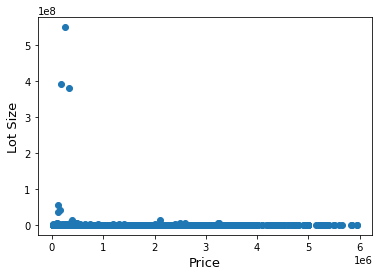

In [93]:
fig, ax = plt.subplots()
ax.scatter(x = train['Price'], y = train['Lot Size'])
plt.ylabel('Lot Size', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()


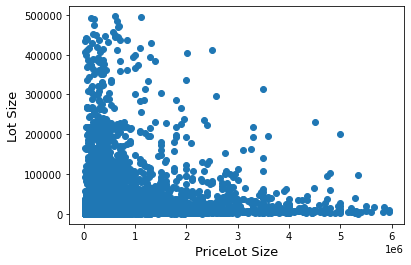

In [94]:
#Deleting outliers
train = train.drop(train[(train['Lot Size']> 0.5*1e6)].index)

#Check the graph again
fig, ax = plt.subplots()
ax.scatter( train['Price'],train['Lot Size'])
plt.xlabel('Price''Lot Size', fontsize=13)
plt.ylabel('Lot Size', fontsize=13)

plt.show()

### Checking and deleting outliers in the Sqr Ft feature

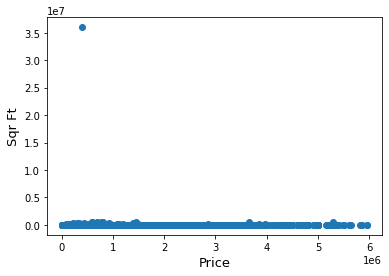

In [95]:
fig, ax = plt.subplots()
ax.scatter(x = train['Price'], y = train['Sqr Ft'])
plt.ylabel('Sqr Ft', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

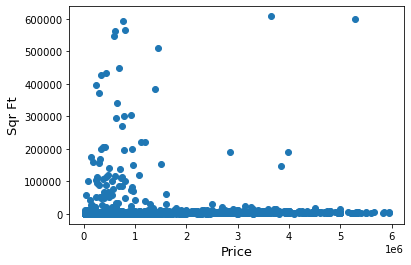

In [96]:
#Deleting outliers
train = train.drop(train[(train['Sqr Ft']> 3.0*1*1e7)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['Price'], train['Sqr Ft'])
plt.ylabel('Sqr Ft', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

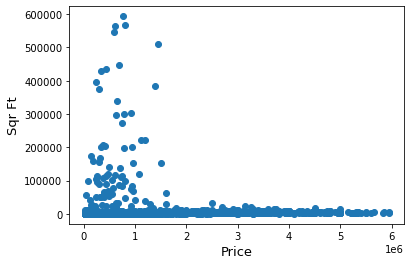

In [97]:
#Deleting outliers
train = train.drop(train[(train['Sqr Ft']> 100000) & (train['Price'] > 2*1e6)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['Price'], train['Sqr Ft'])
plt.ylabel('Sqr Ft', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

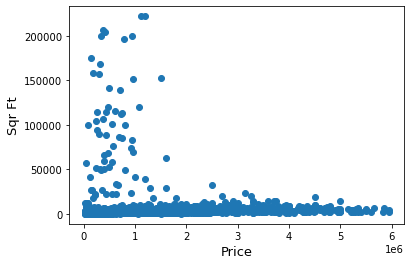

In [98]:
#Deleting outliers again 
train = train.drop(train[(train['Sqr Ft']> 250000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['Price'], train['Sqr Ft'])
plt.ylabel('Sqr Ft', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

### Checking and Deleting outliers in the parking_spaces feature

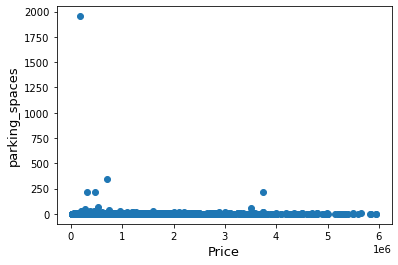

In [99]:
fig, ax = plt.subplots()
ax.scatter(x = train['Price'], y = train['parking_spaces'])
plt.ylabel('parking_spaces', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

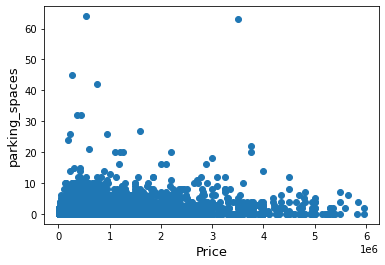

In [100]:
#Deleting outliers
train = train.drop(train[(train['parking_spaces']> 100)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['Price'], train['parking_spaces'])
plt.ylabel('parking_spaces', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

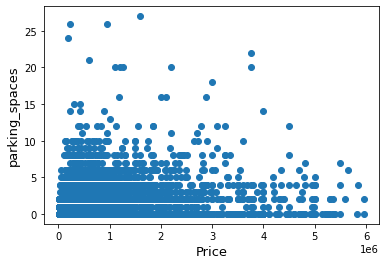

In [101]:
#Deleting outliers
train = train.drop(train[(train['parking_spaces']> 30)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['Price'], train['parking_spaces'])
plt.ylabel('parking_spaces', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

In [102]:
#Check the correlation matrix once again 
# We can see that the correlation with prices increases for some variable (lot size and sqr ft)

corr = train[['Price','Beds', 'Bath', 'Sqr Ft', 'Lot Size', 'Year Built',  
                    'trulia', 'parking_spaces', 'year_updated',
                    'State Tax Revenue', 'Day Length','Number of Images','HouseholdIncome','median_age','perc_white_people']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Price,Beds,Bath,Sqr Ft,Lot Size,Year Built,trulia,parking_spaces,year_updated,State Tax Revenue,Day Length,Number of Images,HouseholdIncome,median_age,perc_white_people
Price,1.000000,0.263782,0.521503,0.117755,0.072629,0.037293,0.072600,0.161234,-0.032184,0.148257,-0.030571,0.115558,0.216104,-0.012327,-0.212740
Beds,0.263782,1.000000,0.620976,0.080824,-0.008719,-0.012365,0.067763,0.200403,0.005187,-0.009215,0.009085,0.050901,0.014901,-0.044837,-0.022636
Bath,0.521503,0.620976,1.000000,0.121231,0.078349,0.260053,0.154233,0.239250,0.056089,-0.042692,-0.088229,0.139741,-0.023366,-0.087245,-0.090909
Sqr Ft,0.117755,0.080824,0.121231,1.000000,0.067797,-0.000770,0.011005,0.032539,-0.027556,0.014744,0.013252,0.011315,0.019286,-0.003070,-0.020335
Lot Size,0.072629,-0.008719,0.078349,0.067797,1.000000,0.053421,0.084456,0.049943,-0.013945,0.004429,-0.024634,0.002065,0.005074,-0.049076,-0.033457
Year Built,0.037293,-0.012365,0.260053,-0.000770,0.053421,1.000000,0.059744,0.080744,0.113969,-0.194015,-0.251142,0.107993,-0.175525,-0.109789,-0.159511
trulia,0.072600,0.067763,0.154233,0.011005,0.084456,0.059744,1.000000,0.015453,0.013439,-0.071386,-0.056063,-0.007644,-0.067559,-0.012114,-0.018013
parking_spaces,0.161234,0.200403,0.239250,0.032539,0.049943,0.080744,0.015453,1.000000,0.036115,-0.017060,-0.067782,0.140030,0.033120,-0.120817,-0.077671
year_updated,-0.032184,0.005187,0.056089,-0.027556,-0.013945,0.113969,0.013439,0.036115,1.000000,-0.034428,-0.029364,0.048141,-0.067361,0.002683,0.036671
State Tax Revenue,0.148257,-0.009215,-0.042692,0.014744,0.004429,-0.194015,-0.071386,-0.017060,-0.034428,1.000000,0.361526,-0.045212,0.392639,-0.054598,-0.038832


### Checking and deleting outliers in the Bath feature

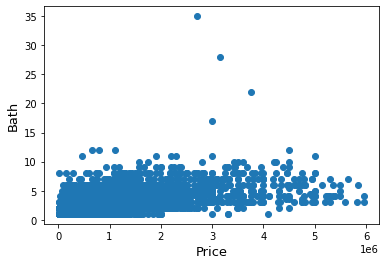

In [103]:
fig, ax = plt.subplots()
ax.scatter(x = train['Price'], y = train['Bath'])
plt.ylabel('Bath', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

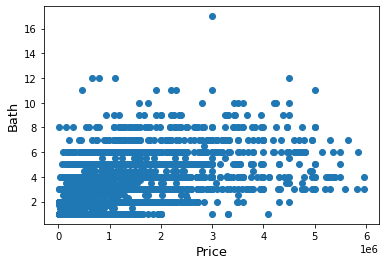

In [104]:
#Deleting outliers
train = train.drop(train[(train['Bath']> 20)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['Price'], train['Bath'])
plt.ylabel('Bath', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

### Checking and Deleting outliers in the Beds feature

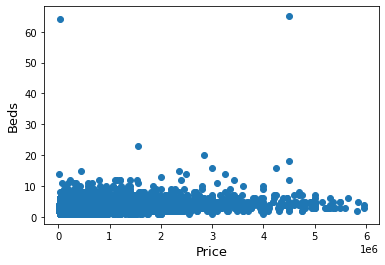

In [105]:
fig, ax = plt.subplots()
ax.scatter(x = train['Price'], y = train['Beds'])
plt.ylabel('Beds', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

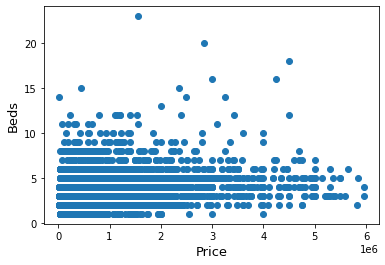

In [106]:
#Deleting outliers
train = train.drop(train[(train['Beds']> 50)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['Price'], train['Beds'])
plt.ylabel('Beds', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

In [107]:
#Check the correlation matrix once again 
#Better correlation with the price for the features Beds and Bath

corr = train[['Price','Beds', 'Bath', 'Sqr Ft', 'Lot Size', 'Year Built',  
                    'trulia', 'parking_spaces', 'year_updated',
                    'State Tax Revenue', 'Day Length','Number of Images','HouseholdIncome','median_age','perc_white_people']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Price,Beds,Bath,Sqr Ft,Lot Size,Year Built,trulia,parking_spaces,year_updated,State Tax Revenue,Day Length,Number of Images,HouseholdIncome,median_age,perc_white_people
Price,1.000000,0.273985,0.525923,0.115292,0.072663,0.037825,0.072554,0.159243,-0.032052,0.148180,-0.032175,0.116362,0.214980,-0.011823,-0.212568
Beds,0.273985,1.000000,0.621085,0.073243,-0.012850,-0.010958,0.069390,0.228789,0.007469,-0.013957,-0.000448,0.066087,0.008706,-0.050042,-0.022684
Bath,0.525923,0.621085,1.000000,0.115258,0.079769,0.268582,0.160152,0.240264,0.058843,-0.044653,-0.100091,0.146948,-0.030636,-0.089265,-0.093921
Sqr Ft,0.115292,0.073243,0.115258,1.000000,0.067674,-0.000695,0.010825,0.031812,-0.027465,0.014640,0.012052,0.011629,0.018342,-0.002796,-0.020118
Lot Size,0.072663,-0.012850,0.079769,0.067674,1.000000,0.053448,0.084382,0.050243,-0.013925,0.004529,-0.025116,0.002104,0.005027,-0.048986,-0.033482
Year Built,0.037825,-0.010958,0.268582,-0.000695,0.053448,1.000000,0.059937,0.081278,0.113953,-0.193998,-0.251509,0.108022,-0.175597,-0.109925,-0.159755
trulia,0.072554,0.069390,0.160152,0.010825,0.084382,0.059937,1.000000,0.016209,0.013462,-0.071375,-0.056465,-0.007494,-0.067527,-0.012034,-0.017974
parking_spaces,0.159243,0.228789,0.240264,0.031812,0.050243,0.081278,0.016209,1.000000,0.036402,-0.017881,-0.067622,0.140486,0.032403,-0.121066,-0.077016
year_updated,-0.032052,0.007469,0.058843,-0.027465,-0.013925,0.113953,0.013462,0.036402,1.000000,-0.034428,-0.029290,0.048134,-0.067320,0.002643,0.036640
State Tax Revenue,0.148180,-0.013957,-0.044653,0.014640,0.004529,-0.193998,-0.071375,-0.017881,-0.034428,1.000000,0.362421,-0.045200,0.392658,-0.054660,-0.038675


#### We tried to remove even more outliers, but even though some variables were better correlated with the price (i.e. the Sqr Ft feature increases to 45% correaltion) , the final prediction were lower. Indeed, the dataset is composed of categories like Multi-family homes or coop which can look outliers but are not.

In [108]:
train.columns

Index(['Crawl Timestamp', 'Url', 'Title', 'Description', 'Price', 'Style',
       'Sqr Ft', 'Longitude', 'Latitude', 'Home Id', 'Lot Size', 'Beds',
       'Bath', 'Year Built', 'Features', 'Address', 'City', 'State', 'Zipcode',
       'Address Full', 'Facts', 'Number of Images', 'Image', 'nearby_airport',
       'Number_crimes', 'Property Type', 'num_of_features', 'HOA', 'trulia',
       'parking_spaces', 'year_updated', 'heating', 'heating_fuel',
       'Great Views', 'Fireplace', 'Furnished', 'Air Conditioning', 'Skylight',
       'Jetted Bath Tub', 'Rv Parking', 'Basement', 'Attic', 'Security System',
       'Fitness Center', 'Basketball Court', 'Tennis Court', 'Sport Court',
       'Doorman', 'Garden', 'Pool', 'Hot Tub or Spa', 'Sauna', 'Pond',
       'Waterfront', 'Double Paned Windows', 'Vaulted Ceiling',
       'Barbeque Area', 'Elevator', 'Gated Entry', 'Intercom',
       'Ranch Architecture', 'Patio', 'Porch', 'Deck', 'Lawn', 'Greenhouse',
       'Dock', 'Sprinkler System', 'D

### Here we add two new columns to the dataset which are transformations of other 2 variables

In [109]:
# Product of the number of beds and baths 

train['prod_beds_bath'] = train['Beds'] * train['Bath']
test['prod_beds_bath'] = test['Beds'] * test['Bath']

In [110]:
train[['Price','prod_beds_bath']].corr()

,Price,prod_beds_bath
Price,1.000000,0.469078
prod_beds_bath,0.469078,1.000000


In [111]:
# Difference of year built and year updated 

train['diff_year_built_updated'] = train['Year Built'] - train['year_updated']
test['diff_year_built_updated'] = test['Year Built'] - test['year_updated']

In [112]:
train[['Price','diff_year_built_updated']].corr()

,Price,diff_year_built_updated
Price,1.000000,0.052543
diff_year_built_updated,0.052543,1.000000


In [113]:
# Product of the number of baths and squarefeet

train['sqrft_beds'] = train['Sqr Ft'] * train['Bath'] 
test['sqrft_beds'] = test['Sqr Ft']*test['Bath'] 

In [114]:
train[['Price', 'sqrft_beds']].corr()

,Price,sqrft_beds
Price,1.00000,0.42855
sqrft_beds,0.42855,1.00000


In [115]:
#Check Correlation matrix for the binary variables
corr = train[['Price','Great Views', 'Fireplace',  'Skylight',
                    'Jetted Bath Tub', 'Rv Parking', 'Basement', 'Attic', 'Security System',
                    'Fitness Center', 'Basketball Court', 'Tennis Court', 'Sport Court',
                    'Doorman', 'Garden', 'Pool', 'Hot Tub or Spa', 'Sauna', 'Pond',
                    'Waterfront','Double Paned Windows','Vaulted Ceiling','Barbeque Area',
                    'Elevator','Gated Entry','Intercom','Ranch Architecture',
                    'Patio','Porch','Deck','Lawn','Greenhouse','Dock','Sprinkler System','Disabled Access']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Price,Great Views,Fireplace,Skylight,Jetted Bath Tub,Rv Parking,Basement,Attic,Security System,Fitness Center,Basketball Court,Tennis Court,Sport Court,Doorman,Garden,Pool,Hot Tub or Spa,Sauna,Pond,Waterfront,Double Paned Windows,Vaulted Ceiling,Barbeque Area,Elevator,Gated Entry,Intercom,Ranch Architecture,Patio,Porch,Deck,Lawn,Greenhouse,Dock,Sprinkler System,Disabled Access
Price,1.000000,0.146944,0.126049,0.096089,0.117727,0.014466,-0.048533,-0.014993,0.108351,0.075415,0.019045,0.039133,0.032151,0.161494,0.149037,0.208249,0.176284,0.074995,0.018090,0.081273,0.061329,0.087048,0.132851,0.182463,0.074326,0.097679,-0.062583,0.056140,0.005954,0.074521,0.048784,0.010274,0.058177,0.113293,-0.023212
Great Views,0.146944,1.000000,0.029899,0.101620,0.143031,0.114258,0.150733,0.069950,0.147780,0.168730,0.083692,0.073970,0.072941,0.092220,0.128949,0.116327,0.165579,0.101443,0.102051,0.179865,0.183036,0.131686,0.205880,0.134087,0.164829,0.084706,-0.005046,0.100294,0.070230,0.117909,0.174257,0.032256,0.099628,0.127388,0.198404
Fireplace,0.126049,0.029899,1.000000,0.160155,0.172423,0.056622,0.205480,0.148551,0.191710,-0.012243,0.003115,0.041017,0.033080,-0.098990,0.082685,0.105056,0.108307,-0.019187,0.024655,-0.029598,0.161495,0.227433,0.113135,-0.113196,0.049220,0.050423,0.047963,0.273863,0.231828,0.238579,0.182471,0.015246,0.000358,0.206705,0.007144
Skylight,0.096089,0.101620,0.160155,1.000000,0.188958,0.077570,0.108486,0.109270,0.170397,0.010430,0.023966,0.067050,0.077136,-0.018243,0.135427,0.083198,0.108893,0.020725,0.049993,0.024333,0.178497,0.266423,0.137823,-0.026959,0.057787,0.092785,0.029532,0.143216,0.082607,0.122574,0.163555,0.038885,0.036346,0.142914,0.038929
Jetted Bath Tub,0.117727,0.143031,0.172423,0.188958,1.000000,0.100951,0.154579,0.228779,0.300649,0.073781,0.076485,0.077510,0.096164,0.006173,0.154320,0.106634,0.202264,0.066575,0.103273,0.056688,0.226818,0.244576,0.216706,0.001632,0.113193,0.160628,0.001736,0.169967,0.145322,0.160616,0.259640,0.029966,0.046041,0.177480,0.021380
Rv Parking,0.014466,0.114258,0.056622,0.077570,0.100951,1.000000,0.051826,0.058999,0.064991,0.008953,0.026669,0.006706,0.044337,-0.031249,0.119308,0.086653,0.097165,0.029742,0.045636,-0.001231,0.171873,0.122492,0.145891,-0.044183,0.035632,0.017957,0.077858,0.145920,0.107623,0.041953,0.156882,0.070420,0.025890,0.099714,0.069188
Basement,-0.048533,0.150733,0.205480,0.108486,0.154579,0.051826,1.000000,0.300208,0.198649,0.006732,0.013552,-0.012507,0.027725,-0.072290,0.161039,-0.057105,0.017824,-0.011849,0.051648,-0.034572,0.165705,0.149402,0.156323,-0.091975,0.011944,0.021081,0.159732,0.120244,0.163802,0.213955,0.326901,0.025990,0.005726,0.091974,0.103356
Attic,-0.014993,0.069950,0.148551,0.109270,0.228779,0.058999,0.300208,1.000000,0.276125,0.006580,0.061648,0.030595,0.060066,-0.049633,0.185196,0.009647,0.030665,-0.007080,0.074079,0.023289,0.207077,0.179303,0.202436,-0.071452,0.037539,0.041996,0.070462,0.144695,0.207672,0.142473,0.385060,0.022128,0.028216,0.132807,-0.002406
Security System,0.108351,0.147780,0.191710,0.170397,0.300649,0.064991,0.198649,0.276125,1.000000,0.093567,0.109077,0.095280,0.115403,-0.010001,0.196388,0.112107,0.134548,0.037620,0.118525,0.039827,0.257201,0.255697,0.257411,0.000438,0.160191,0.148503,0.025411,0.239818,0.216034,0.176965,0.350958,0.029168,0.037769,0.295536,-0.004525
Fitness Center,0.075415,0.168730,-0.012243,0.010430,0.073781,0.008953,0.006732,0.006580,0.093567,1.000000,0.158312,0.161652,0.146402,0.175105,0.025730,0.158236,0.177951,0.167052,0.052576,0.066290,0.089395,0.032242,0.179348,0.217465,0.246493,0.053129,-0.024284,0.087256,0.035509,0.028863,0.032670,0.017221,0.056802,0.087943,0.063973


## 5. Data preprocessing

In [116]:
# Define numeric, categorical and binary features to be included in the learning system

numeric_features = [
    
                    'Beds', 'Bath', 'Sqr Ft', 'Lot Size', 'Year Built',  
                    'trulia', 'parking_spaces', 'year_updated',
                    'State Tax Revenue', 'Day Length','Number of Images','perc_white_people',
                    'median_age','HouseholdIncome','prod_beds_bath','diff_year_built_updated'
                    ]

binary_features = [
                    'Great Views', 'Fireplace',  'Skylight',
                    'Jetted Bath Tub', 'Rv Parking', 'Basement', 'Attic', 'Security System',
                    'Fitness Center', 'Basketball Court', 'Tennis Court', 'Sport Court',
                    'Doorman', 'Garden', 'Pool', 'Hot Tub or Spa', 'Sauna', 'Pond',
                    'Waterfront','Double Paned Windows','Vaulted Ceiling','Barbeque Area',
                    'Elevator','Gated Entry','Intercom','Ranch Architecture',
                    'Patio','Porch','Deck','Lawn','Greenhouse','Dock','Sprinkler System','Disabled Access'

                   ]



categorical_features = ['Property Type', 'State','heating','heating_fuel']  # , 'City', 'Zipcode'

In [117]:
# Define pipelines for categorical and numerical features
categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler())])

In [118]:
# Build preprocessor
preprocessor = ColumnTransformer(
        transformers=[
                ('cat', categorical_transformer, categorical_features),
                ('num', numerical_transformer, numeric_features+binary_features)])

In [119]:
# Define pipeline 
pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', AdaBoostRegressor())])

In [120]:
#define different base estimator to try for the adaboost regressor

# The model is greatly improved thanks to a good choice of base estimator. Fore example, using the default base estimator,
# which is a tree regressor, we attain a rmse of around 450'000. However, using a bagging regressor ,stacking regressor
# or simply another regressor (random forest regressor), we attain a score of around 350'000. Prediction
# with one of these three base estimators are quite similar, but the last one (Random forest regressor) is quicker 
# to run.

# xgboost as base estimator

params_xgboost= {'lambda': 3.55,
                 'alpha': 0.25,
                 'colsample_bytree': 0.6,
                 'subsample': 0.5,
                 'learning_rate': 0.014,
                 'n_estimators': 4000,
                 'max_depth': 11,
                 'random_state': 24,
                 'min_child_weight': 3}

base_model_xgboost = XGBRegressor(**params_xgboost)

# elastic net as base estimator

base_estimator_elsaticnet = ElasticNet(random_state=0)

#bagging model as base estimator
base_estimator_bagging = RandomForestRegressor(n_estimators= 10,
                                               criterion= 'mse',
                                               max_features = 'sqrt',
                                               min_samples_split = 5,
                                               random_state = 40)


base_model_bagging = BaggingRegressor(base_estimator=base_estimator_bagging,
                                      n_estimators = 10,
                                      random_state =40)



#stacking model as base estimator
estimators_stacking = [
     
    ('etr', ExtraTreesRegressor(n_estimators= 5,
                          criterion= 'mse',
                          max_features = 'log2',
                          random_state = 40)),
    ('gbr', GradientBoostingRegressor(learning_rate = 1,
                                     n_estimators= 10,
                                     random_state = 40))]


base_model_stacking = StackingRegressor(
                                estimators=estimators_stacking,
                                final_estimator=RandomForestRegressor(n_estimators= 5,
                                                                      criterion= 'mse',
                                                                      max_features = 'sqrt',
                                                                      min_samples_split = 3,
                                                                      random_state = 40))

#random forest as base estimator
base_model_random_forest = RandomForestRegressor(n_estimators= 5,
                                                       criterion= 'mse',
                                                       max_features = 'sqrt',
                                                       min_samples_split = 3,
                                                       random_state = 40)  

base_estimator_list = [base_model_random_forest,base_model_stacking,base_estimator_elsaticnet]


#### To allow you to run the entire file more quickly, we set the base estimator to the default one and the parameter n_estimators is set very low too, but we tried  using grid  search a large set of possibilities. In general, the model with the larger number of estimators and a stacking model or a RandomForest Regressor as base estimator leads to better results but it increases the running time quite a lot.

In [121]:
# Define values for hyper parameters
param_grid = {
    'preprocessor__num__imputer__strategy': ['median'], # the mean gives is general lower results
    #'regressor__base_estimator': [base_model_random_forest], #here we tried with the whole set defined inthe cell above
    'regressor__n_estimators':[200], # the higher  the value, the better the prediction but sharp increases in running time too
    'regressor__learning_rate':[0.05]} #this is the one giving the higher score 
    

In [122]:
# Define ML-system
ml_system = GridSearchCV(pipeline, 
                         param_grid, 
                         cv=3,
                         scoring='neg_root_mean_squared_error', 
                         return_train_score=True,
                         verbose=2) 

In [123]:
# Prepare data
features = numeric_features + binary_features + categorical_features
X_train = train[features]
y_train = train['Price']
X_test = test[features]


In [124]:
# Perform grid search and refit with best parameters
ml_system.fit(X_train, y_train);

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END preprocessor__num__imputer__strategy=median, regressor__base_estimator=RandomForestRegressor(criterion='mse', max_features='sqrt', min_samples_split=3,
                      n_estimators=5, random_state=40), regressor__learning_rate=0.05, regressor__n_estimators=3000; total time=10.0min
[CV] END preprocessor__num__imputer__strategy=median, regressor__base_estimator=RandomForestRegressor(criterion='mse', max_features='sqrt', min_samples_split=3,
                      n_estimators=5, random_state=40), regressor__learning_rate=0.05, regressor__n_estimators=3000; total time= 8.9min
[CV] END preprocessor__num__imputer__strategy=median, regressor__base_estimator=RandomForestRegressor(criterion='mse', max_features='sqrt', min_samples_split=3,
                      n_estimators=5, random_state=40), regressor__learning_rate=0.05, regressor__n_estimators=3000; total time= 9.6min


In [125]:
# Create dataframe of gridsearch results
results = pd.DataFrame(ml_system.cv_results_)

In [126]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num__imputer__strategy,param_regressor__base_estimator,param_regressor__learning_rate,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,500.633849,13.398382,69.227548,18.443996,median,"RandomForestRegressor(criterion='mse', max_features='sqrt', min_samples_split=3,\n ...",0.05,3000,"{'preprocessor__num__imputer__strategy': 'median', 'regressor__base_estimator': RandomForestRegr...",-309724.630534,-336511.352322,-340450.959775,-328895.647544,13651.032845,1,-44568.665298,-44073.314665,-43968.102897,-44203.360953,261.855974


In [127]:
# Select specific columns from dataframe
hyperparameters = ['param_' + key for key in param_grid.keys()]
scores = ['split' + str(i) + '_test_score' for i in range(ml_system.cv)]
columns = hyperparameters + scores + ['mean_test_score', 
                                      'mean_train_score']
results = results[columns].copy()

In [128]:
# Replace column names
mapper = dict(zip(hyperparameters, ['strategy', 'alpha']))
results.rename(columns=mapper, inplace=True)

In [129]:
# Multiply mean_test_score by -1 and sort in ascending order
score_columns = results.columns[results.columns.str.contains('score')]
results[score_columns] = results[score_columns] * -1

In [130]:
results.sort_values(by='mean_test_score').round(1)

,strategy,alpha,param_regressor__n_estimators,param_regressor__learning_rate,split0_test_score,split1_test_score,split2_test_score,mean_test_score,mean_train_score
0,median,"RandomForestRegressor(criterion='mse', max_features='sqrt', min_samples_split=3,\n ...",3000,0.05,309724.6,336511.4,340451.0,328895.6,44203.4


In [131]:
# Compute predictions for test set
y_test_pred = ml_system.predict(X_test)

## 6. Predict prices for test set

In [132]:
# Prepare submission
submission = pd.DataFrame(columns=['Uniq Id', 'Price'])
submission['Uniq Id'] = test.index
submission['Price'] = y_test_pred
submission.to_csv('submission_adaboost.csv', index=False)

### We tried to run the machine learning system on a smaller set of features (the ones having a correaltion with the price hier than 8%) but still, the best model was the one the whole set of features)

In [133]:
most_correlated_features = [f"{corr.columns[i]} and {corr.columns[j]}" for i, j in zip(*np.where(np.abs(corr.values) > 0.07)) if i < j]